## **Time Series Modelling Case Study**

In [1]:
# 🚀 Mount Google Drive to access data files stored there
from google.colab import drive
drive.mount('/content/drive')

# 📦 Import essential libraries
import pandas as pd                  # Data manipulation
import numpy as np                   # Numerical operations
from datetime import datetime        # Handling date/time formats

# 📊 Plotting libraries
import matplotlib.pyplot as plt      # Main plotting library
import seaborn as sns                # Enhances matplotlib for cleaner visuals

# 📈 Time series statistical tests and models
from statsmodels.tsa.stattools import adfuller, kpss    # Stationarity tests
from statsmodels.tsa.arima.model import ARIMA           # ARIMA model

# 🔍 Model evaluation and tuning tools
from itertools import product                           # Useful for parameter grid search
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ⚠️ Ignore warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# 📈 Time series visualization tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF & PACF plots


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **PART 1**

### **Performing EDA**

In [2]:
# 📂 Step 1: Define the file path to your dataset in Google Drive
file_path = '/content/drive/MyDrive/oil_price.csv'  # ⬅️ Replace with actual path if different
df = pd.read_csv(file_path)

# 🧼 Step 2: Check for missing values before processing
print("🔍 Initial Missing Values Check:")
print(df.isnull().sum())

# 🧹 Step 3: Drop any rows that contain missing values
df = df.dropna()

# 📆 Step 4: Convert the 'Date' column to datetime type and set it as the index
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')  # e.g., "Jan 01, 2020"
df.set_index('Date', inplace=True)

# 🔍 Step 5: Re-check for any remaining missing values
print("\n❓ Missing Values After Cleaning:")
print(df.isnull().sum())

# 👀 Step 6: Display the first few rows to verify the structure
display(df.head())  # Only works in Jupyter/Colab for pretty table view
print(df.info())    # Summary of index, column types, non-null counts

# 📊 Step 7: Show descriptive statistics (mean, std, min, max, etc.)
print("\n📈 Descriptive Statistics:")
print(df.describe())


🔍 Initial Missing Values Check:
Date     595
Price    595
dtype: int64

❓ Missing Values After Cleaning:
Price    0
dtype: int64


,Price
Date,
2020-07-01,42.18
2020-07-02,43.19
2020-07-03,42.92
2020-07-06,42.73
2020-07-07,43.28


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 635 entries, 2020-07-01 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   635 non-null    float64
dtypes: float64(1)
memory usage: 9.9 KB
None

📈 Descriptive Statistics:
            Price
count  635.000000
mean    77.214110
std     23.898162
min     36.330000
25%     61.130000
50%     75.500000
75%     94.275000
max    133.180000


### **Making initial plots of the data**

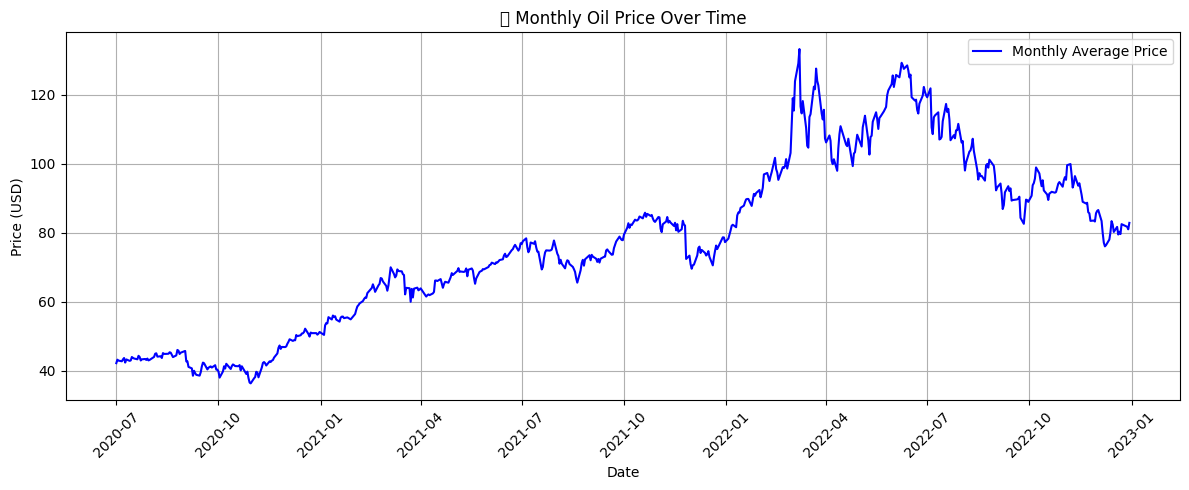

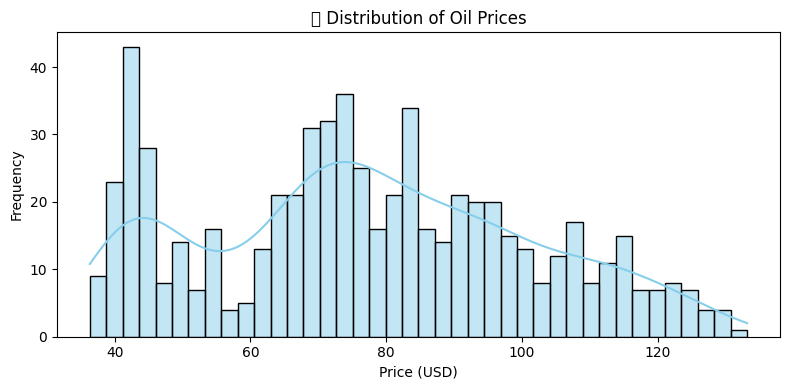

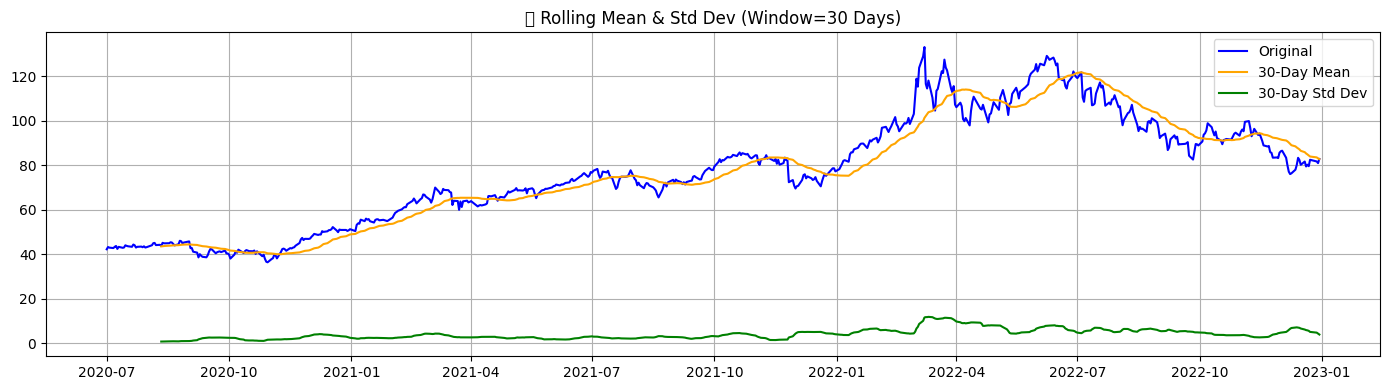

🔁 ACF and PACF Analysis:


<Figure size 1000x400 with 0 Axes>

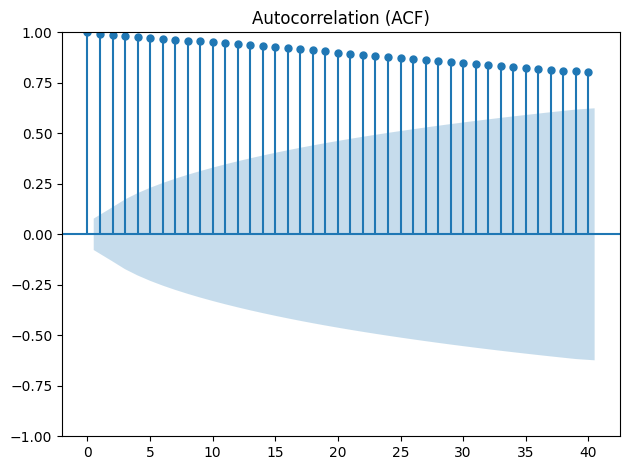

<Figure size 1000x400 with 0 Axes>

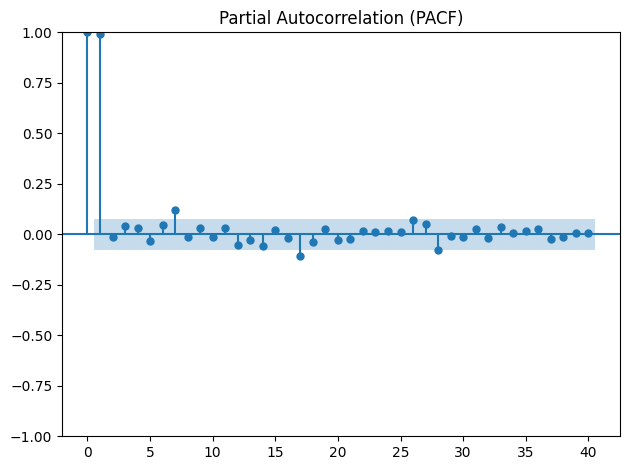

In [3]:
# 📦 Import necessary libraries for plotting and time series analysis
import matplotlib.pyplot as plt             # For basic plotting
import seaborn as sns                      # For advanced statistical visualizations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation plots

# 📌 Function 1: Line plot of the time series data
def plot_time_series(df):
    """
    Plots the raw time series of oil prices.
    Useful for identifying overall trends, seasonality, and anomalies.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['Price'], label='Monthly Average Price', color='blue')  # Line plot of price over time
    plt.title("📈 Monthly Oil Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# 📌 Function 2: Histogram of the price distribution
def plot_price_distribution(df):
    """
    Plots a histogram with a KDE (kernel density estimate) to show the distribution of oil prices.
    Helps in assessing skewness, normality, and outliers in the price data.
    """
    plt.figure(figsize=(8, 4))
    sns.histplot(df['Price'], bins=40, kde=True, color='skyblue')  # Histogram + density curve
    plt.title("📊 Distribution of Oil Prices")
    plt.xlabel("Price (USD)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 📌 Function 3: Rolling mean and standard deviation
def plot_rolling_statistics(df, window=30):
    """
    Visualizes the rolling (moving) mean and standard deviation over time.
    This is a basic technique to check for stationarity in time series data.
    A 30-day rolling window is used by default.
    """
    roll_mean = df['Price'].rolling(window).mean()   # Compute rolling mean
    roll_std = df['Price'].rolling(window).std()     # Compute rolling standard deviation

    plt.figure(figsize=(14, 4))
    plt.plot(df['Price'], label='Original', color='blue')         # Original series
    plt.plot(roll_mean, label=f'{window}-Day Mean', color='orange')  # Rolling mean
    plt.plot(roll_std, label=f'{window}-Day Std Dev', color='green')  # Rolling std
    plt.title(f"📉 Rolling Mean & Std Dev (Window={window} Days)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📌 Function 4: ACF and PACF Plots
def plot_acf_pacf(df, lags=40):
    """
    Displays Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
    These are diagnostic tools used for identifying the order of ARIMA models.
    """
    print("🔁 ACF and PACF Analysis:")

    # ACF plot: shows correlation of current series with lagged versions
    plt.figure(figsize=(10, 4))
    plot_acf(df['Price'], lags=lags)
    plt.title("Autocorrelation (ACF)")
    plt.tight_layout()
    plt.show()

    # PACF plot: shows correlation with lagged values after removing effects of intermediate lags
    plt.figure(figsize=(10, 4))
    plot_pacf(df['Price'], lags=lags, method='ywm')  # 'ywm' is a stable method for PACF computation
    plt.title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()


# =============================
# ✅ Calling functions in order
# =============================

# Plot the raw time series to visualize trends and seasonality
plot_time_series(df)

# Plot distribution of prices to understand normality and skewness
plot_price_distribution(df)

# Plot rolling statistics to help assess stationarity visually
plot_rolling_statistics(df)

# Plot ACF and PACF to determine AR and MA terms for modeling
plot_acf_pacf(df)


## **Performing all the time series analysis tasks to test for non-stationarity**

In [4]:
# Importing statistical tests for stationarity from statsmodels
from statsmodels.tsa.stattools import adfuller, kpss

# 📌 Function to run ADF test
def run_adf_test(series):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check for stationarity in a time series.

    Parameters:
        series (pd.Series): Time series data to test

    Returns:
        None. Prints out the test statistic, p-value, and critical values.
    """
    print("📉 Augmented Dickey-Fuller (ADF) Test:")

    # Run the ADF test
    adf_result = adfuller(series)

    # Print the ADF test statistic
    print(f"ADF Statistic: {adf_result[0]:.4f}")

    # Print the p-value (used to decide stationarity)
    print(f"p-value: {adf_result[1]:.4f}")

    # Print critical values at different significance levels (1%, 5%, 10%)
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")

    # Interpretation: If p-value > 0.05, the series is non-stationary
    print("=> Conclusion:", "Non-stationary ❌" if adf_result[1] > 0.05 else "Stationary ✅")
    print("\n")


# 📌 Function to run KPSS test
def run_kpss_test(series, regression='c'):
    """
    Performs the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test to assess stationarity.
    This test complements ADF by reversing the null hypothesis (stationary vs. non-stationary).

    Parameters:
        series (pd.Series): Time series data to test
        regression (str): Type of regression.
                          'c' for constant (level stationarity),
                          'ct' for constant and trend (trend stationarity)

    Returns:
        None. Prints out the test statistic, p-value, and critical values.
    """
    print("📉 KPSS Test:")

    # Run the KPSS test
    kpss_result = kpss(series, regression=regression, nlags='auto')

    # Print the KPSS test statistic
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")

    # Print the p-value
    print(f"p-value: {kpss_result[1]:.4f}")

    # Print critical values at different significance levels
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")

    # Interpretation: If p-value < 0.05, the series is non-stationary
    print("=> Conclusion:", "Non-stationary ❌" if kpss_result[1] < 0.05 else "Stationary ✅")
    print("\n")

# ✅ Run both tests on the 'Price' column of the DataFrame to evaluate stationarity
run_adf_test(df['Price'])   # ADF test (null hypothesis: non-stationary)
run_kpss_test(df['Price'])  # KPSS test (null hypothesis: stationary)


📉 Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: -1.5986
p-value: 0.4843
Critical Values:
   1%: -3.4410
   5%: -2.8662
   10%: -2.5693
=> Conclusion: Non-stationary ❌


📉 KPSS Test:
KPSS Statistic: 3.1261
p-value: 0.0100
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
=> Conclusion: Non-stationary ❌




### **Making the data stationary**

In [5]:
# 📦 Import required stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# 📌 Step: Create a copy of the original series for transformation
series = df['Price'].copy()  # Avoid modifying the original DataFrame

# 📊 Step: Run stationarity tests on original series
adf_result = adfuller(series.dropna())               # Augmented Dickey-Fuller test
kpss_result = kpss(series.dropna(), regression='c')  # KPSS test with constant (level stationarity)

# 📊 Step: Check results of stationarity tests
# If ADF p-value > 0.05 (non-stationary) OR KPSS p-value < 0.05 (non-stationary)
if adf_result[1] > 0.05 or kpss_result[1] < 0.05:

    # 🧮 Apply first-order differencing to make the series stationary
    series = series.diff().dropna()
    print("⤴️ First-order differencing applied — now stationary.")

else:
    # ✅ If both tests confirm stationarity, no need to transform
    print("✅ Series is already stationary.")


⤴️ First-order differencing applied — now stationary.


In [6]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# ✅ Step 1: Ensure data is clean and sorted
df = df.sort_index()         # Ensure time series is sorted chronologically
df = df.dropna()             # Drop any missing values

# ✅ Step 2: Apply first-order differencing to stabilize the series
df_diff = df['Price'].diff().dropna()  # Differencing helps remove trends and seasonality

# ✅ Step 3: Perform ADF Test for stationarity
adf_result = adfuller(df_diff)

print("📉 ADF Test After First-Order Differencing:")
print(f"ADF Statistic       : {adf_result[0]:.4f}")
print(f"p-value             : {adf_result[1]:.4f}")
print("Critical Values     :")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")
# Interpretation based on p-value
print("=> Result: " + ("✅ Stationary" if adf_result[1] < 0.05 else "❌ Non-stationary"))

# ✅ Step 4: Perform KPSS Test for confirming stationarity
kpss_result = kpss(df_diff, regression='c', nlags='auto')

print("\n📈 KPSS Test After First-Order Differencing:")
print(f"KPSS Statistic      : {kpss_result[0]:.4f}")
print(f"p-value             : {kpss_result[1]:.4f}")
print("Critical Values     :")
for key, value in kpss_result[3].items():
    print(f"   {key}: {value:.4f}")
# Interpretation based on p-value
print("=> Result: " + ("✅ Stationary" if kpss_result[1] > 0.05 else "❌ Non-stationary"))


📉 ADF Test After First-Order Differencing:
ADF Statistic       : -5.2786
p-value             : 0.0000
Critical Values     :
   1%: -3.4410
   5%: -2.8662
   10%: -2.5693
=> Result: ✅ Stationary

📈 KPSS Test After First-Order Differencing:
KPSS Statistic      : 0.1387
p-value             : 0.1000
Critical Values     :
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
=> Result: ✅ Stationary


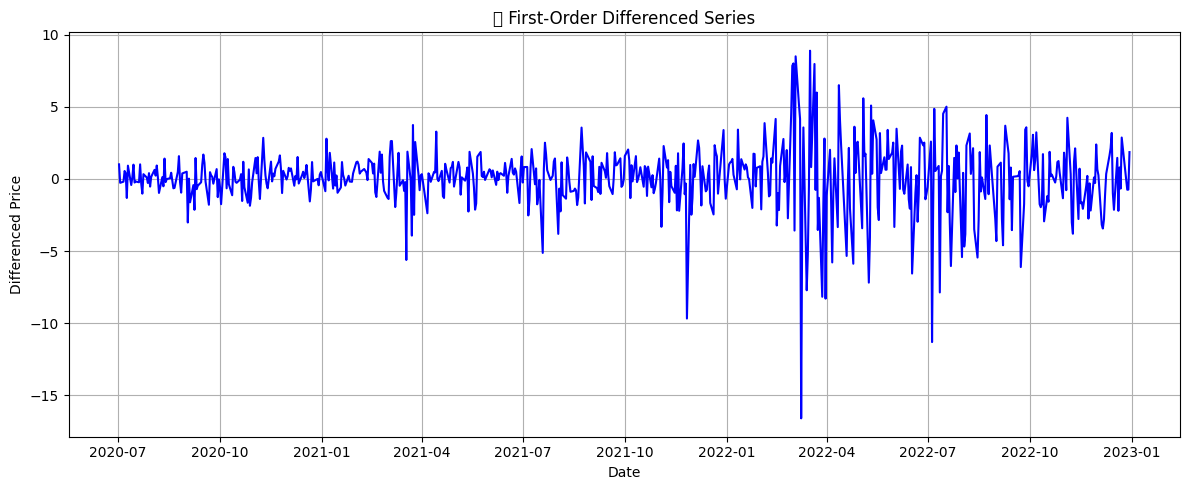

<Figure size 1000x400 with 0 Axes>

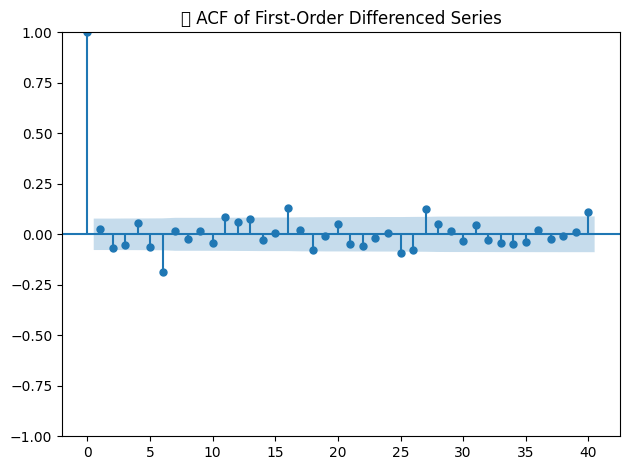

<Figure size 1000x400 with 0 Axes>

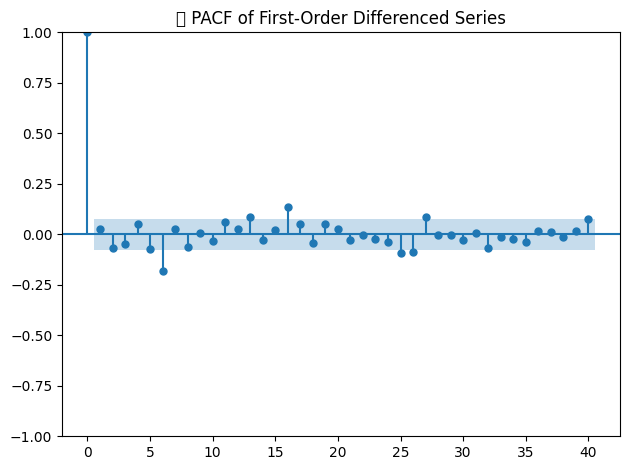

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 📌 Function to apply first-order differencing
def apply_first_order_differencing(series):
    """
    Applies first-order differencing to a time series to make it stationary.

    Parameters:
        series (pd.Series): Original time series.

    Returns:
        pd.Series: Differenced series.
    """
    return series.diff().dropna()

# 📌 Function to plot the differenced time series
def plot_differenced_series(diff_series):
    """
    Plots the first-order differenced series.

    Parameters:
        diff_series (pd.Series): Differenced series to be plotted.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(diff_series, color='blue')
    plt.title("📉 First-Order Differenced Series")
    plt.xlabel("Date")
    plt.ylabel("Differenced Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📌 Function to plot ACF and PACF
def plot_acf_pacf(diff_series, lags=40):
    """
    Plots the ACF and PACF for the differenced time series.

    Parameters:
        diff_series (pd.Series): Differenced time series.
        lags (int): Number of lags to display.
    """
    # ACF Plot
    plt.figure(figsize=(10, 4))
    plot_acf(diff_series, lags=lags)
    plt.title("🔁 ACF of First-Order Differenced Series")
    plt.tight_layout()
    plt.show()

    # PACF Plot
    plt.figure(figsize=(10, 4))
    plot_pacf(diff_series, lags=lags, method='ywm')
    plt.title("🔁 PACF of First-Order Differenced Series")
    plt.tight_layout()
    plt.show()

# ========================
# ✅ Call functions below
# ========================

# Step 1: Apply differencing
df_diff = apply_first_order_differencing(df['Price'])

# Step 2: Plot differenced series
plot_differenced_series(df_diff)

# Step 3: Plot ACF and PACF
plot_acf_pacf(df_diff)


### **ARMA model**

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# 📌 Function: Fit ARMA model (ARIMA with d=0)
def fit_arma_model(series, order=(2, 0, 2)):
    """
    Fits an ARMA model to a time series using ARIMA with d=0.

    Parameters:
        series (pd.Series): A stationary time series.
        order (tuple): (p, d, q) parameters for ARIMA (d must be 0 for ARMA).

    Returns:
        result: Fitted ARIMA model.
    """
    print(f"🔧 Fitting ARMA model with order={order}...")
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit

# 📌 Function: Display ARMA model summary
def display_model_summary(model_fit):
    """
    Prints the summary of a fitted ARMA model.

    Parameters:
        model_fit: The result object from ARIMA fit.
    """
    print("📄 ARMA Model Summary:")
    print(model_fit.summary())

# ========================
# ✅ Run Model Fitting
# ========================

# Ensure `df_diff` is already computed from earlier differencing step
arma_model_fit = fit_arma_model(df_diff, order=(2, 0, 2))
display_model_summary(arma_model_fit)


🔧 Fitting ARMA model with order=(2, 0, 2)...
📄 ARMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  634
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1406.538
Date:                Sun, 06 Jul 2025   AIC                           2825.076
Time:                        21:15:05   BIC                           2851.788
Sample:                             0   HQIC                          2835.449
                                - 634                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0644      0.094      0.687      0.492      -0.119       0.248
ar.L1         -0.0305      0.028     -1.105      0.269      -0.0

### Find the best model parameters: p,d,q using the AIC for p=[0,8], d=[0,2] and q=[0,8]

In [9]:
import pandas as pd
import warnings
from statsmodels.tsa.arima.model import ARIMA

# 📌 Function: Perform ARIMA grid search using AIC
def arima_grid_search(series, p_range=range(0, 8), d_range=range(0, 3), q_range=range(0, 8)):
    """
    Perform a grid search to find the best ARIMA(p,d,q) model based on AIC.

    Parameters:
        series (pd.Series): Time series data.
        p_range, d_range, q_range: Ranges for ARIMA p, d, q parameters.

    Returns:
        best_model (ARIMAResults): Fitted ARIMA model with the lowest AIC.
        best_order (tuple): The (p,d,q) order of the best model.
        best_aic (float): The AIC value of the best model.
    """
    warnings.filterwarnings("ignore")  # Suppress convergence warnings
    best_aic = float('inf')
    best_order = None
    best_model = None

    print("🔍 Starting ARIMA Grid Search...\n")

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    aic = model.aic
                    print(f"Tested ARIMA({p},{d},{q}) → AIC: {aic:.2f}")
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue  # Skip models that fail to converge

    return best_model, best_order, best_aic

# 📌 Function: Print summary of best ARIMA model
def display_arima_summary(model, order, aic):
    """
    Display the summary of the best ARIMA model.

    Parameters:
        model: Fitted ARIMA model.
        order (tuple): Best (p,d,q) order.
        aic (float): AIC of best model.
    """
    print("\n✅ Best ARIMA order:", order)
    print(f"✅ Best AIC: {aic:.2f}")
    print(f"\n📘 Fitting ARIMA{order} model for summary...\n")
    print(model.summary())

# ============================================
# ✅ RUN: ARIMA model selection and evaluation
# ============================================

# Replace with your actual time series if not already defined
series = df['Price']  # Ensure this is a pandas Series

# Perform ARIMA grid search
best_model, best_order, best_aic = arima_grid_search(series)

# Display the model summary
display_arima_summary(best_model, best_order, best_aic)


🔍 Starting ARIMA Grid Search...

Tested ARIMA(0,0,0) → AIC: 5835.78
Tested ARIMA(0,0,1) → AIC: 5022.87
Tested ARIMA(0,0,2) → AIC: 4444.60
Tested ARIMA(0,0,3) → AIC: 4011.92
Tested ARIMA(0,0,4) → AIC: 3815.91
Tested ARIMA(0,0,5) → AIC: 3598.46
Tested ARIMA(0,0,6) → AIC: 3474.51
Tested ARIMA(0,0,7) → AIC: 3369.70
Tested ARIMA(0,1,0) → AIC: 2835.10
Tested ARIMA(0,1,1) → AIC: 2836.59
Tested ARIMA(0,1,2) → AIC: 2836.21
Tested ARIMA(0,1,3) → AIC: 2834.37
Tested ARIMA(0,1,4) → AIC: 2835.42
Tested ARIMA(0,1,5) → AIC: 2835.04
Tested ARIMA(0,1,6) → AIC: 2817.93
Tested ARIMA(0,1,7) → AIC: 2818.73
Tested ARIMA(0,2,0) → AIC: 3252.98
Tested ARIMA(0,2,1) → AIC: 2839.58
Tested ARIMA(0,2,2) → AIC: 2841.03
Tested ARIMA(0,2,3) → AIC: 2840.73
Tested ARIMA(0,2,4) → AIC: 2838.95
Tested ARIMA(0,2,5) → AIC: 2839.97
Tested ARIMA(0,2,6) → AIC: 2839.62
Tested ARIMA(0,2,7) → AIC: 2822.17
Tested ARIMA(1,0,0) → AIC: 2846.81
Tested ARIMA(1,0,1) → AIC: 2848.22
Tested ARIMA(1,0,2) → AIC: 2848.02
Tested ARIMA(1,0,3) → 

### **Forecast model 24 months into the future**


📉 ADF Test (Original Monthly Data)
ADF Statistic: -0.6019717857051007
p-value: 0.8705358613311815
Critical Values: {'1%': np.float64(-3.8092091249999998), '5%': np.float64(-3.0216450000000004), '10%': np.float64(-2.6507125)}
➡️ Non-stationary

📉 ADF Test (Differenced Monthly Data)
ADF Statistic: -3.1881649571717112
p-value: 0.020680040095024423
Critical Values: {'1%': np.float64(-3.8092091249999998), '5%': np.float64(-3.0216450000000004), '10%': np.float64(-2.6507125)}
➡️ Stationary


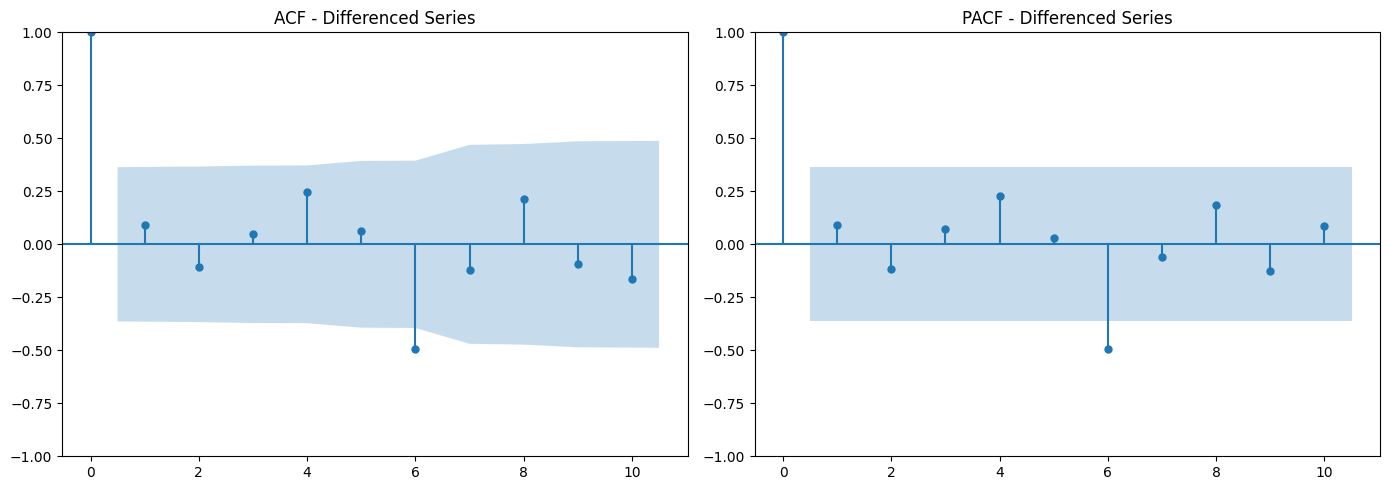

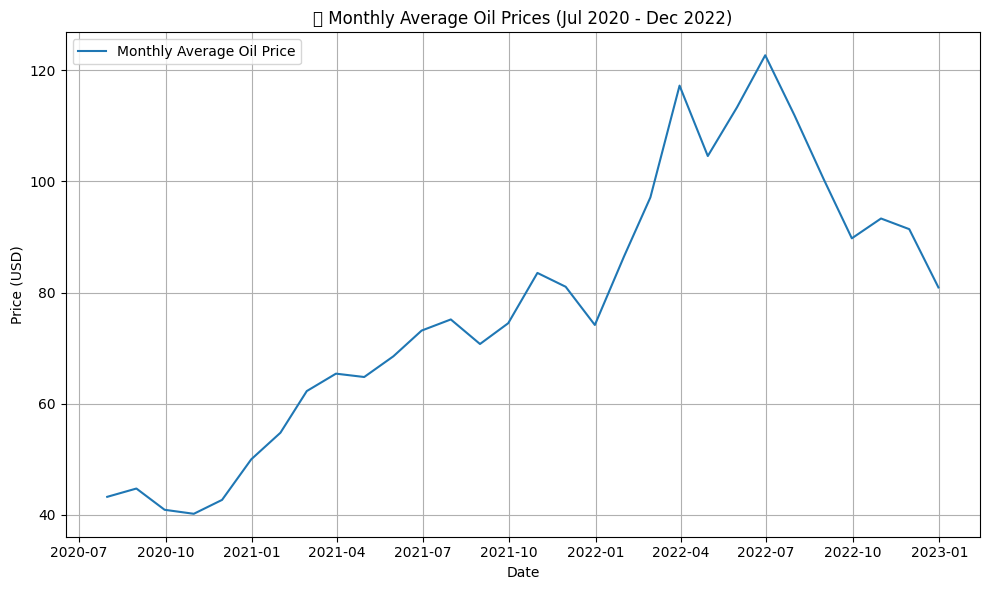


✅ Best ARIMA Order: (2, 1, 4) with AIC: 200.85


In [10]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller                     # ADF test for stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf     # ACF and PACF plots
from statsmodels.tsa.arima.model import ARIMA                     # ARIMA modeling
import warnings
warnings.filterwarnings("ignore")                                 # Suppress warnings for cleaner output

# -----------------------------------
# 📌 Function: Resample to monthly average
# -----------------------------------
def resample_monthly(df):
    """
    Converts daily or higher-frequency price data into monthly averages.

    Parameters:
        df (DataFrame): Must contain a datetime index and a 'Price' column.

    Returns:
        Series: Monthly averaged price.
    """
    return df['Price'].resample('M').mean()

# -----------------------------------
# 📌 Function: Perform ADF test
# -----------------------------------
def run_adf_test(series, title="ADF Test"):
    """
    Runs the Augmented Dickey-Fuller (ADF) test to assess stationarity.

    Parameters:
        series (Series): Time series data.
        title (str): Custom title for display.

    Prints:
        Test statistic, p-value, and critical values.
    """
    result = adfuller(series.dropna())
    print(f"\n📉 {title}")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    print("➡️ Stationary" if result[1] < 0.05 else "➡️ Non-stationary")

# -----------------------------------
# 📌 Function: Plot ACF and PACF
# -----------------------------------
def plot_acf_pacf(series, lags=10):
    """
    Plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    for lag analysis, used in ARIMA modeling.

    Parameters:
        series (Series): The (differenced) time series.
        lags (int): Number of lags to show in the plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(series, ax=axes[0], lags=lags)
    plot_pacf(series, ax=axes[1], lags=lags, method='ywm')
    axes[0].set_title("ACF - Differenced Series")
    axes[1].set_title("PACF - Differenced Series")
    plt.tight_layout()
    plt.show()

# -----------------------------------
# 📌 Function: ARIMA Grid Search for Best AIC
# -----------------------------------
def find_best_arima(series, p_max=8, q_max=8, d=1):
    """
    Performs a grid search over ARIMA(p,d,q) parameters to find the best model
    based on Akaike Information Criterion (AIC).

    Parameters:
        series (Series): Time series to model.
        p_max (int): Max AR terms.
        q_max (int): Max MA terms.
        d (int): Degree of differencing (default = 1).

    Returns:
        Tuple: Best (p,d,q) order and corresponding AIC.
    """
    best_aic = float("inf")
    best_order = None
    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                model = ARIMA(series, order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
            except:
                continue  # Skip invalid models silently
    print(f"\n✅ Best ARIMA Order: {best_order} with AIC: {best_aic:.2f}")
    return best_order, best_aic

# -----------------------------------
# 📌 Function: Plot original series
# -----------------------------------
def plot_monthly_series(series):
    """
    Plots the resampled monthly time series to visualize trends and patterns.

    Parameters:
        series (Series): Monthly-averaged price data.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Monthly Average Oil Price')
    plt.title('📈 Monthly Average Oil Prices (Jul 2020 - Dec 2022)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===========================
# ✅ Main Execution Pipeline
# ===========================

# Step 1: Resample the original 'df' DataFrame to monthly frequency using the average price
df_monthly = resample_monthly(df)

# Step 2: Run ADF test on the original monthly series to check for stationarity
run_adf_test(df_monthly, title="ADF Test (Original Monthly Data)")

# Step 3: Apply first-order differencing to remove trend (if necessary)
df_monthly_diff = df_monthly.diff().dropna()

# Step 4: Run ADF test again to check if differencing made the series stationary
run_adf_test(df_monthly_diff, title="ADF Test (Differenced Monthly Data)")

# Step 5: Plot ACF and PACF to help identify suitable p and q parameters for ARIMA
plot_acf_pacf(df_monthly_diff)

# Step 6: Plot the original monthly series to visualize the data before modeling
plot_monthly_series(df_monthly)

# Step 7: Perform a grid search over (p,d,q) to find the ARIMA model with the best AIC
best_order, best_aic = find_best_arima(df_monthly, p_max=8, q_max=8, d=1)


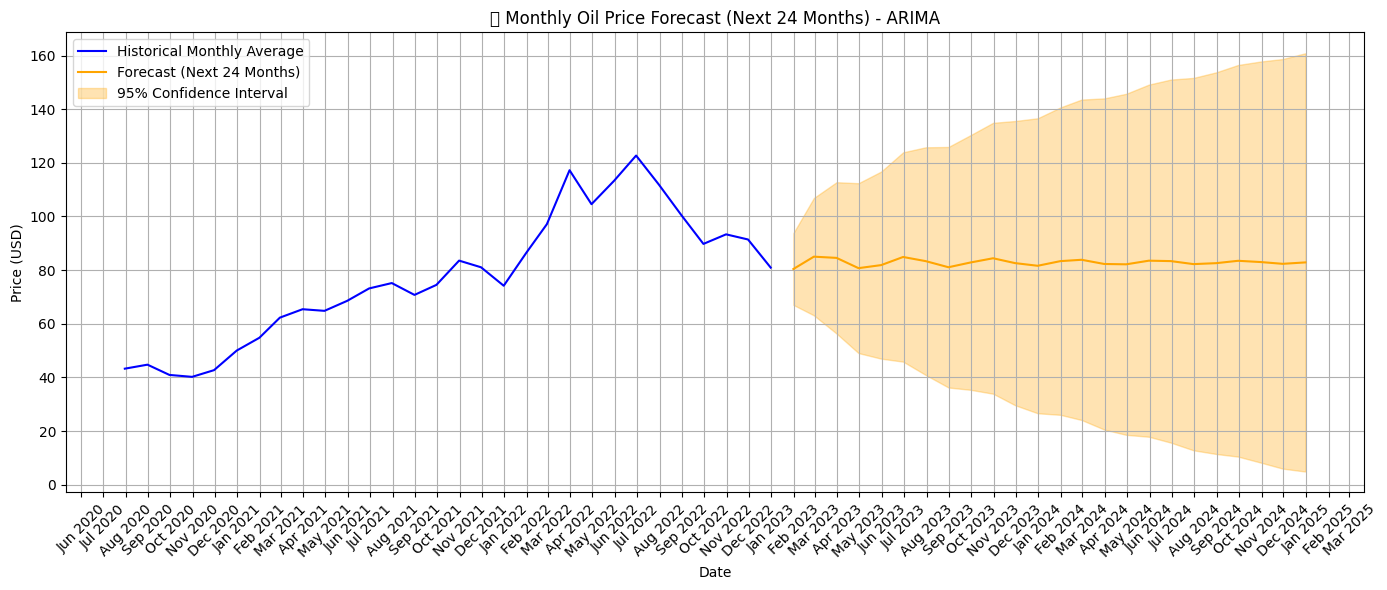

📉 In-sample RMSE: 10.44 USD


In [11]:
# 📦 Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA                  # ARIMA model for time series forecasting
from sklearn.metrics import mean_squared_error                 # RMSE metric
import warnings
warnings.filterwarnings("ignore")                              # Suppress all warnings (e.g., convergence)

# ===============================
# 📌 Function to Forecast with ARIMA
# ===============================
def arima_forecast_plot(df, order=(2, 1, 2), forecast_steps=24):
    """
    Fits an ARIMA model on monthly resampled data, performs forecast, plots result with confidence bands,
    and calculates in-sample RMSE.

    Parameters:
        df (DataFrame): Must contain a datetime index and a 'Price' column
        order (tuple): ARIMA order (p, d, q)
        forecast_steps (int): Number of months to forecast ahead
    """

    # 🗓 Step 1: Resample to monthly average prices (if original data is daily or irregular)
    df_monthly = df['Price'].resample('M').mean()

    # 🧠 Step 2: Fit ARIMA model to the monthly average prices
    model = ARIMA(df_monthly, order=order)                     # Instantiate ARIMA with (p,d,q) order
    result = model.fit()                                       # Fit the model

    # 🔮 Step 3: Forecast next 'forecast_steps' months
    forecast = result.get_forecast(steps=forecast_steps)       # Generate forecast object
    forecast_mean = forecast.predicted_mean                    # Forecasted values
    conf_int = forecast.conf_int()                             # Confidence intervals (default: 95%)

    # 🕓 Step 4: Build future monthly date range for the forecast
    forecast_index = pd.date_range(
        start=df_monthly.index[-1] + pd.offsets.MonthEnd(1),   # Start 1 month after last point
        periods=forecast_steps, freq='M'
    )

    # Convert forecast results and confidence intervals to NumPy arrays for plotting
    mean_forecast = forecast_mean.values.astype(float)
    lower_bound = conf_int.iloc[:, 0].values.astype(float)
    upper_bound = conf_int.iloc[:, 1].values.astype(float)

    # 📊 Step 5: Plot historical data, forecast, and confidence interval
    plt.figure(figsize=(14, 6))
    plt.plot(df_monthly, label='Historical Monthly Average', color='blue')
    plt.plot(forecast_index, mean_forecast, label='Forecast (Next 24 Months)', color='orange')
    plt.fill_between(forecast_index, lower_bound, upper_bound,
                     color='orange', alpha=0.3, label='95% Confidence Interval')

    # 📅 Format x-axis to show monthly labels
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())              # Monthly tick marks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))    # Month Year format
    plt.xticks(rotation=45)

    # 🔖 Labels and titles
    plt.title('📈 Monthly Oil Price Forecast (Next 24 Months) - ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📉 Step 6: Evaluate model with in-sample RMSE (fit error)
    fitted_vals = result.fittedvalues                                   # Fitted values from model
    aligned_actuals = df_monthly.loc[fitted_vals.index]                # Align actuals to fitted index
    rmse = np.sqrt(mean_squared_error(aligned_actuals, fitted_vals))   # Root Mean Squared Error
    print(f"📉 In-sample RMSE: {rmse:.2f} USD")                         # Output model accuracy

# ==================================
# ✅ Example Usage with your dataset
# ==================================
# Make sure your DataFrame `df`:
# - Has a datetime index
# - Contains a 'Price' column with numeric values

arima_forecast_plot(df, order=(2, 1, 2), forecast_steps=24)


In [12]:
# 📦 Import necessary libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf                     # For autocorrelation function
from scipy.stats import pearsonr                              # For Pearson correlation
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)
from statsmodels.tsa.arima.model import ARIMA                 # ARIMA time series model

# ✅ Ensure df has datetime index and 'Price' column
# Resample to monthly average prices for consistent time steps
df_monthly = df['Price'].resample('M').mean()

# 📈 Fit ARIMA model (2,1,2) on monthly price data
model = ARIMA(df_monthly, order=(2, 1, 2))
result = model.fit()

# 🔍 Get model's fitted values (in-sample predictions) and align with actual data
fitted_vals = result.fittedvalues
aligned_actuals = df_monthly.loc[fitted_vals.index]

# 📉 Calculate residuals (forecast errors)
error = aligned_actuals - fitted_vals

# ✅ Advanced Performance Metrics

# ➤ Mean Error (bias): Average of residuals
ME = np.mean(error)

# ➤ Mean Absolute Error: Average of absolute residuals
MAE = mean_absolute_error(aligned_actuals, fitted_vals)

# ➤ Mean Percentage Error: Average percentage error (can be skewed by small actuals)
MPE = np.mean(error / aligned_actuals) * 100

# ➤ Mean Absolute Percentage Error: More robust average percentage error
MAPE = np.mean(np.abs(error / aligned_actuals)) * 100

# ➤ Root Mean Squared Error: Heavily penalizes large errors
RMSE = np.sqrt(mean_squared_error(aligned_actuals, fitted_vals))

# ➤ Lag-1 autocorrelation of residuals: should be near 0 for well-fitted model
ACF1 = acf(error, nlags=1)[1]

# ➤ Pearson correlation coefficient between actuals and fitted values
corr, _ = pearsonr(aligned_actuals, fitted_vals)

# ➤ Min-Max Error: Measures average proportional deviation
minmax = 1 - np.mean(np.minimum(aligned_actuals, fitted_vals) / np.maximum(aligned_actuals, fitted_vals))

# ➤ R² (coefficient of determination): Proportion of variance explained by the model
R2 = r2_score(aligned_actuals, fitted_vals)

# ➤ Median Absolute Error: Robust to outliers
MedAE = median_absolute_error(aligned_actuals, fitted_vals)

# ➤ Standard Deviation of Residuals: Spread of forecast errors
std_error = np.std(error)

# 🖨️ Print all evaluation metrics
print(f"📊 Mean Error (ME): {ME:.4f}")
print(f"📉 Mean Absolute Error (MAE): {MAE:.4f}")
print(f"📊 Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"📉 Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"📉 Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"📈 Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"🔗 Correlation (corr): {corr:.4f}")
print(f"📏 Min-Max Error: {minmax:.4f}")
print(f"📈 R-squared (R²): {R2:.4f}")
print(f"📉 Median Absolute Error (MedAE): {MedAE:.4f}")
print(f"📊 Standard Deviation of Error: {std_error:.4f}")


📊 Mean Error (ME): 2.6068
📉 Mean Absolute Error (MAE): 6.5578
📊 Mean Percentage Error (MPE): 4.98%
📉 Mean Absolute Percentage Error (MAPE): 9.61%
📉 Root Mean Squared Error (RMSE): 10.4370
📈 Lag 1 Autocorrelation of Error (ACF1): -0.0532
🔗 Correlation (corr): 0.9321
📏 Min-Max Error: 0.0944
📈 R-squared (R²): 0.8037
📉 Median Absolute Error (MedAE): 4.1170
📊 Standard Deviation of Error: 10.1062


### **Retrieve the oil price data to the current date and plot with your forecast as a comparison.**

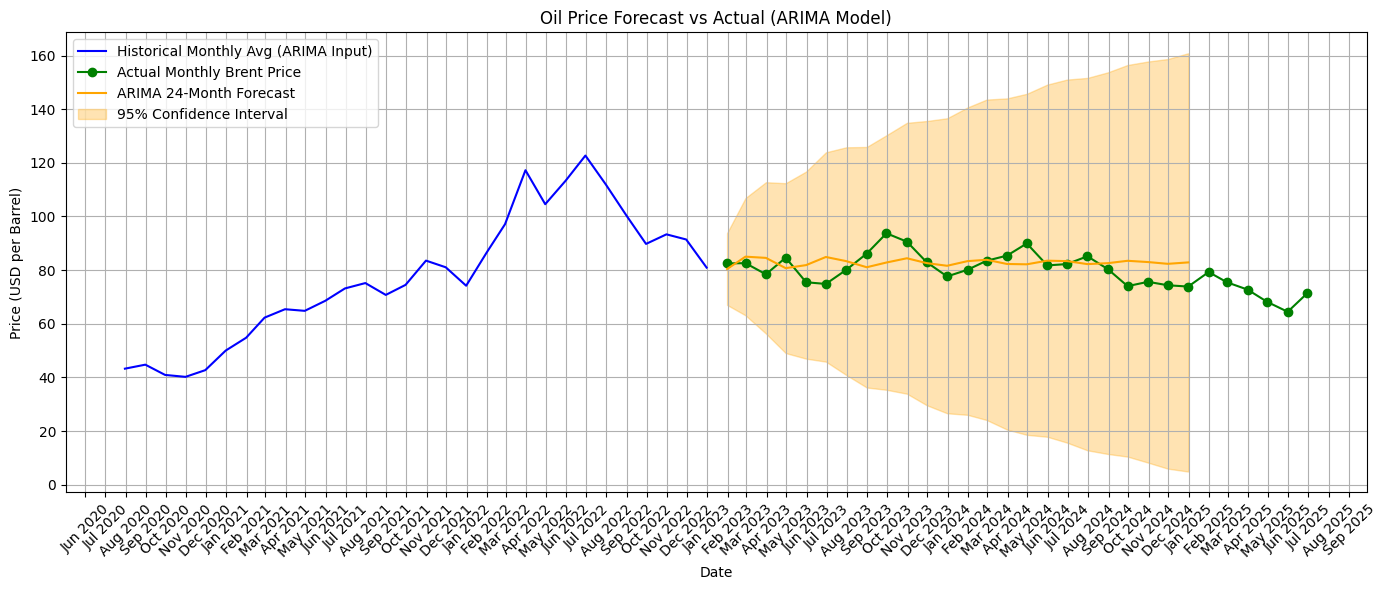

📉 In-sample RMSE: 10.44 USD


In [13]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr                     # For retrieving external financial data
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA                # ARIMA model
import matplotlib.dates as mdates                            # For formatting date axis in plots
from sklearn.metrics import mean_squared_error               # For RMSE calculation
import warnings
warnings.filterwarnings("ignore")                            # Suppress ARIMA convergence warnings

# 📌 Function: Fit ARIMA model and forecast
def arima_forecast(df, order=(2, 1, 2), steps=24):
    """
    Fits an ARIMA model on a monthly time series and forecasts future values.

    Parameters:
        df (pd.Series): Monthly time series indexed by datetime.
        order (tuple): ARIMA order (p, d, q).
        steps (int): Number of months to forecast ahead.

    Returns:
        forecast_index (DatetimeIndex): Forecasted future dates.
        forecast_mean (np.array): Forecasted values.
        conf_int (DataFrame): Confidence intervals (95% by default).
        model_fit (ARIMAResults): Fitted ARIMA model object.
    """
    model = ARIMA(df, order=order)
    model_fit = model.fit()

    forecast = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    forecast_index = pd.date_range(
        start=df.index[-1] + pd.offsets.MonthEnd(1),
        periods=steps,
        freq='M'
    )

    return forecast_index, forecast_mean.values, conf_int, model_fit


# ✅ Step 1: Resample original oil price data to monthly averages
df_monthly = df['Price'].resample('M').mean()

# ✅ Step 2: Fit ARIMA model and generate 24-month forecast
best_order = (2, 1, 2)  # Replace with optimal ARIMA order if known
forecast_index, forecast_mean_array, conf_int, result = arima_forecast(
    df_monthly, order=best_order, steps=24
)
lower_array = conf_int.iloc[:, 0].values      # Lower confidence interval bound
upper_array = conf_int.iloc[:, 1].values      # Upper confidence interval bound

# ✅ Step 3: Get actual Brent oil prices from FRED for model validation
start = datetime(2023, 1, 1)
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)  # Pull from FRED (daily frequency)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()         # Resample to monthly for alignment

# ✅ Step 4: Plot historical data, forecast, and real Brent prices
plt.figure(figsize=(14, 6))

# ➤ Historical ARIMA input data
plt.plot(df_monthly, label='Historical Monthly Avg (ARIMA Input)', color='blue')

# ➤ Actual observed Brent prices (ground truth)
plt.plot(brent_monthly.index, brent_monthly['Price'], label='Actual Monthly Brent Price',
         color='green', marker='o')

# ➤ Forecasted values with confidence bands
plt.plot(forecast_index, forecast_mean_array, label='ARIMA 24-Month Forecast', color='orange')
plt.fill_between(forecast_index, lower_array, upper_array,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# 📅 Axis formatting
plt.title('Oil Price Forecast vs Actual (ARIMA Model)')
plt.xlabel("Date")
plt.ylabel("Price (USD per Barrel)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())               # Monthly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))     # Format as 'Jan 2023'
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Optional: In-sample RMSE to evaluate model fit
fitted_vals = result.fittedvalues                      # In-sample predictions
aligned_actual = df_monthly.loc[fitted_vals.index]     # Actuals aligned to prediction index
rmse = np.sqrt(mean_squared_error(aligned_actual, fitted_vals))
print(f"📉 In-sample RMSE: {rmse:.2f} USD")


### **PART 2**

### **Build the required model**

### **Prophet  Model**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdisztwo0/qtak19gg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdisztwo0/tdworpxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56694', 'data', 'file=/tmp/tmpdisztwo0/qtak19gg.json', 'init=/tmp/tmpdisztwo0/tdworpxy.json', 'output', 'file=/tmp/tmpdisztwo0/prophet_modeljq5az9kt/prophet_model-20250706212227.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:

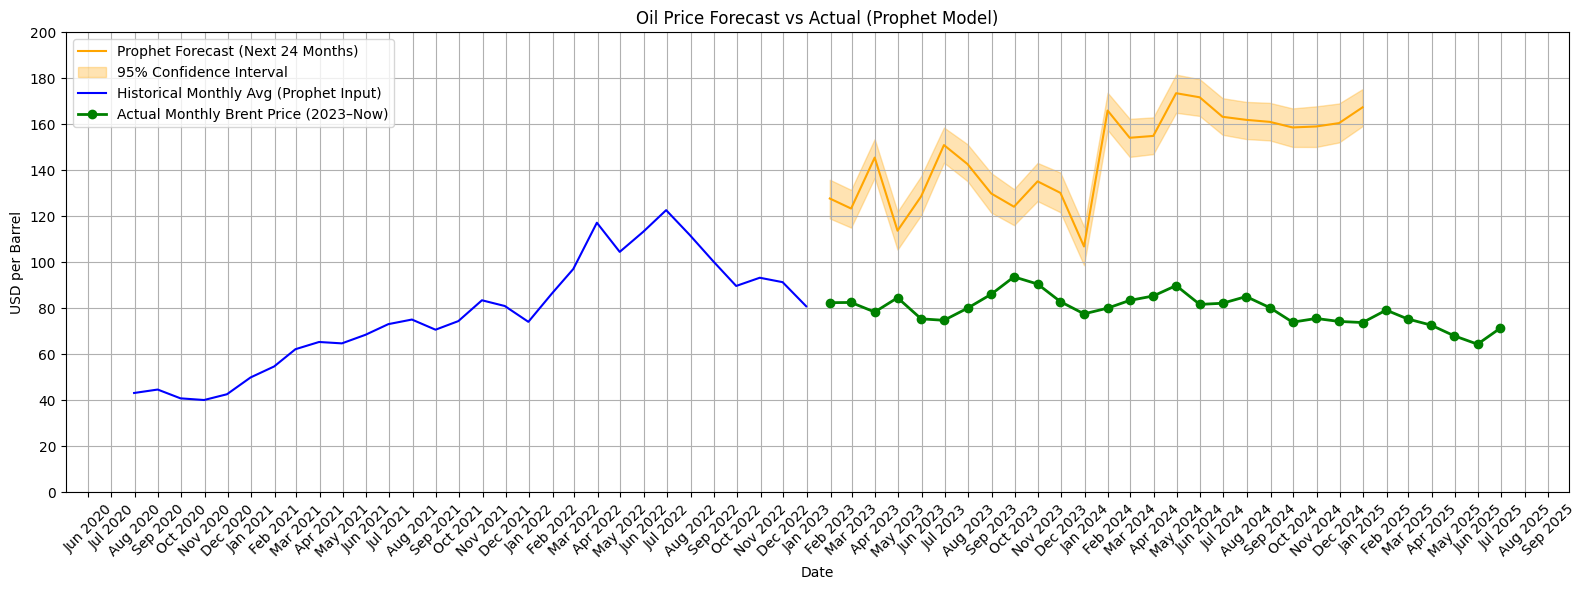

In [14]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.dates as mdates

# 🔧 Load and preprocess oil price data
def load_oil_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df_monthly = df['Price'].resample('M').mean()
    return df_monthly

# 🧠 Train Prophet model
def train_prophet_model(df_monthly, cutoff_date):
    df_train = df_monthly[:cutoff_date].reset_index()
    df_train.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df_train)
    return model

# 🔮 Forecast with Prophet
def forecast_with_prophet(model, cutoff_date, months_ahead=24):
    future = model.make_future_dataframe(periods=months_ahead, freq='M')
    forecast = model.predict(future)
    forecast_filtered = forecast[forecast['ds'] > cutoff_date]
    return forecast_filtered

# 🛢 Fetch actual Brent prices from FRED
def get_actual_brent(start_date, end_date):
    brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start_date, end_date)
    brent_daily.columns = ['Price']
    brent_monthly = brent_daily.resample('M').mean().dropna()
    return brent_monthly

# 📈 Plot forecast vs actuals
def plot_prophet_forecast(df_monthly, cutoff_date, forecast, actual_brent):
    plt.figure(figsize=(16, 6))

    # Forecasted values and confidence intervals
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast (Next 24 Months)', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3,
                     label='95% Confidence Interval')

    # Historical data
    plt.plot(df_monthly[:cutoff_date], label='Historical Monthly Avg (Prophet Input)', color='blue')

    # Actual Brent data
    plt.plot(actual_brent.index, actual_brent['Price'], label='Actual Monthly Brent Price (2023–Now)',
             color='green', marker='o', linewidth=2)

    # Plot formatting
    plt.title("Oil Price Forecast vs Actual (Prophet Model)")
    plt.xlabel("Date")
    plt.ylabel("USD per Barrel")
    plt.ylim(0, 200)
    plt.yticks(np.arange(0, 201, 20))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🚀 Main execution block
if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/oil_price.csv'
    cutoff_date = '2022-12-31'
    start = datetime(2023, 1, 1)
    end = datetime.today()

    df_monthly = load_oil_data(file_path)
    model = train_prophet_model(df_monthly, cutoff_date)
    forecast_filtered = forecast_with_prophet(model, cutoff_date)
    actual_brent = get_actual_brent(start, end)
    plot_prophet_forecast(df_monthly, cutoff_date, forecast_filtered, actual_brent)


## ** Evaluation Metrics for Prophet**

In [15]:
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)

def evaluate_forecast(forecast_df, actual_df, forecast_col='yhat', actual_col='Price', date_col='ds'):
    """
    Evaluate time series forecast accuracy with multiple metrics.

    Parameters:
        forecast_df (DataFrame): Forecast output with date_col and forecast_col
        actual_df (DataFrame): Actual values with datetime index and actual_col
        forecast_col (str): Column name for predicted values
        actual_col (str): Column name for actual values
        date_col (str): Column name for datetime in forecast_df

    Returns:
        dict: Dictionary of performance metrics
    """
    # Align forecast with actuals by date
    forecast_df = forecast_df[forecast_df[date_col] >= actual_df.index[0]].copy()
    forecast_df.set_index(date_col, inplace=True)

    combined = pd.merge(actual_df, forecast_df[[forecast_col]],
                        left_index=True, right_index=True, how='inner')

    actual = combined[actual_col].values
    predicted = combined[forecast_col].values
    error = actual - predicted

    metrics = {
        "ME": np.mean(error),
        "MAE": mean_absolute_error(actual, predicted),
        "MPE": np.mean(error / actual) * 100,
        "MAPE": np.mean(np.abs(error / actual)) * 100,
        "RMSE": np.sqrt(mean_squared_error(actual, predicted)),
        "ACF1": acf(error, nlags=1)[1] if len(error) > 1 else np.nan,
        "Correlation": pearsonr(actual, predicted)[0],
        "MinMaxError": 1 - np.mean(np.minimum(actual, predicted) / np.maximum(actual, predicted)),
        "R2": r2_score(actual, predicted),
        "MedAE": median_absolute_error(actual, predicted),
        "StdError": np.std(error)
    }

    # Pretty print results
    print("\n📊 Forecast Evaluation Metrics:")
    for key, val in metrics.items():
        if isinstance(val, float):
            if 'Error' in key or key in ['MAE', 'MedAE', 'RMSE', 'StdError', 'ME']:
                print(f"{key:>15}: {val:.4f}")
            elif 'PE' in key or key == 'Correlation':
                print(f"{key:>15}: {val:.2f}%")
            else:
                print(f"{key:>15}: {val:.4f}")
    return metrics

    # Evaluate Prophet forecast
metrics = evaluate_forecast(forecast_filtered, brent_monthly)




📊 Forecast Evaluation Metrics:
             ME: -64.8340
            MAE: 64.8340
            MPE: -80.63%
           MAPE: 80.63%
           RMSE: 68.0551
           ACF1: 0.5338
    Correlation: -0.21%
    MinMaxError: 0.4319
             R2: -161.8761
          MedAE: 70.1257
       StdError: 20.6895


### **XG BOOST**

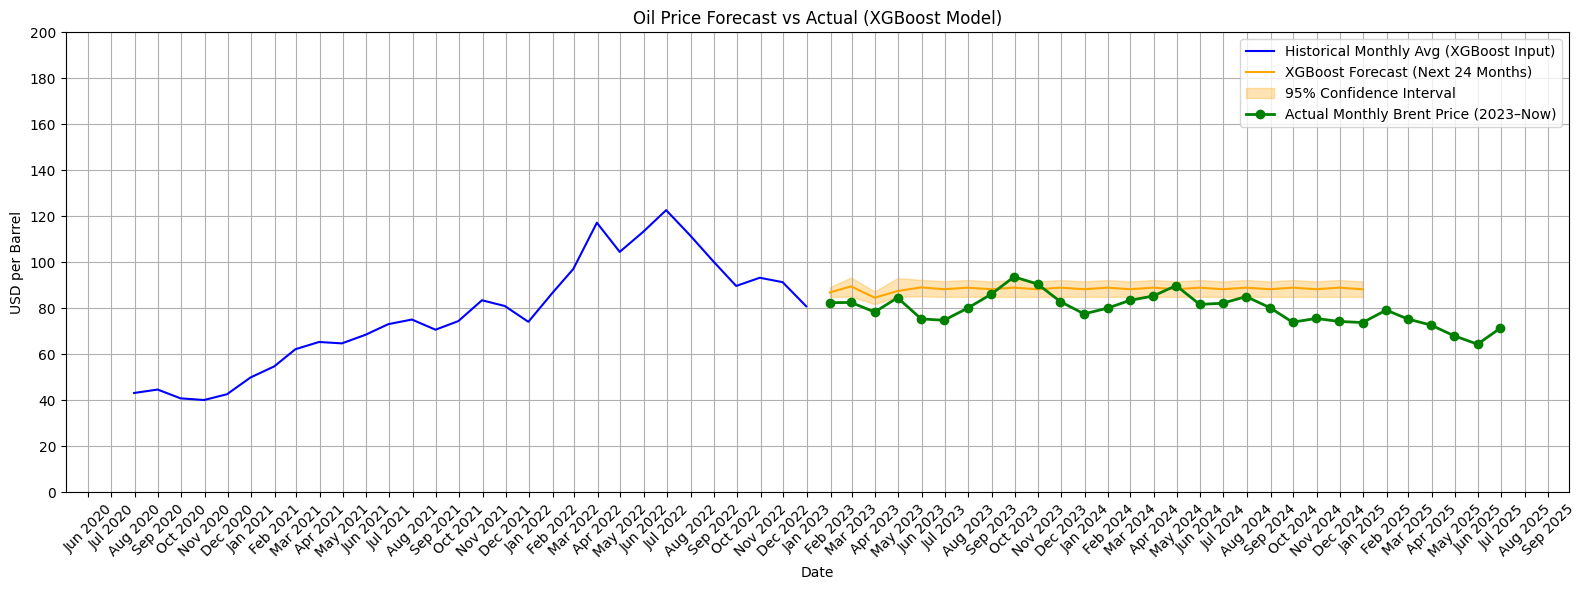

In [16]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor                         # Gradient boosting model
from pandas_datareader import data as pdr               # For external Brent data
from datetime import datetime
import matplotlib.dates as mdates                       # For date formatting on plots

# ✅ Step 1: Resample daily data to monthly average
df_monthly = df['Price'].resample('M').mean()

# ✅ Step 2: Create lagged features for supervised learning
def create_lagged_features(series, n_lags=12):
    """
    Transforms a time series into a supervised learning format with lag features.

    Parameters:
        series (Series): Time series to transform
        n_lags (int): Number of lag months to include

    Returns:
        DataFrame: DataFrame with 'Price' and its lagged values
    """
    df_lag = pd.DataFrame(series)
    for i in range(1, n_lags + 1):
        df_lag[f'lag_{i}'] = df_lag['Price'].shift(i)
    df_lag.dropna(inplace=True)
    return df_lag

lagged_df = create_lagged_features(df_monthly, n_lags=12)
X = lagged_df.drop(columns='Price')    # Features: previous 12 months
y = lagged_df['Price']                 # Target: current month

# ✅ Step 3: Fit base XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model.fit(X, y)

# ✅ Step 4: Bootstrap predictions to estimate confidence intervals
n_bootstraps = 100            # Number of simulated models
future_steps = 24             # Months to forecast
boot_predictions = np.zeros((n_bootstraps, future_steps))

for b in range(n_bootstraps):
    model_b = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')

    # Add noise to target for variation
    noise = np.random.normal(0, 0.5, size=y.shape)
    model_b.fit(X, y + noise)

    # Rolling prediction for future steps using last 12 known values
    last_known = df_monthly[-12:].values.copy()
    preds = []

    for _ in range(future_steps):
        input_data = pd.DataFrame([last_known[-12:][::-1]], columns=[f'lag_{i}' for i in range(1, 13)])
        pred = model_b.predict(input_data)[0]
        preds.append(pred)
        last_known = np.append(last_known, pred)[-12:]

    boot_predictions[b] = preds

# ✅ Step 5: Aggregate predictions
forecast_mean = boot_predictions.mean(axis=0)
lower_bound = np.percentile(boot_predictions, 2.5, axis=0)
upper_bound = np.percentile(boot_predictions, 97.5, axis=0)

forecast_index = pd.date_range(
    start=df_monthly.index[-1] + pd.offsets.MonthEnd(1),
    periods=future_steps, freq='M'
)

# ✅ Step 6: Load actual Brent oil prices (for comparison)
start = datetime(2023, 1, 1)
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()

# ✅ Step 7: Plot forecast vs actual
plt.figure(figsize=(16, 6))

# ➤ Historical training data
plt.plot(df_monthly, label='Historical Monthly Avg (XGBoost Input)', color='blue')

# ➤ Forecast and confidence interval
plt.plot(forecast_index, forecast_mean, label='XGBoost Forecast (Next 24 Months)', color='orange')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='orange', alpha=0.3,
                 label='95% Confidence Interval')

# ➤ Ground truth Brent prices
plt.plot(brent_monthly.index, brent_monthly['Price'],
         label='Actual Monthly Brent Price (2023–Now)', color='green', marker='o', linewidth=2)

# ✅ Plot formatting
plt.title("Oil Price Forecast vs Actual (XGBoost Model)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 200)
plt.yticks(np.arange(0, 201, 20))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## ** Evaluation Metrics for XGBoost**

In [17]:
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr

# ✅ Align actuals with forecast (only where actual data is available)
actual = brent_monthly['Price'].loc[forecast_index].dropna()
predicted = pd.Series(forecast_mean, index=forecast_index).loc[actual.index]

# ✅ Calculate error
error = actual.values - predicted.values

# ✅ Metrics
ME = np.mean(error)
MAE = mean_absolute_error(actual, predicted)
MPE = np.mean(error / actual) * 100
MAPE = np.mean(np.abs(error / actual)) * 100
RMSE = np.sqrt(mean_squared_error(actual, predicted))
ACF1 = acf(error, nlags=1)[1] if len(error) > 1 else np.nan
corr, _ = pearsonr(actual, predicted)
minmax = 1 - np.mean(np.minimum(actual, predicted) / np.maximum(actual, predicted))
R2 = r2_score(actual, predicted)
MedAE = median_absolute_error(actual, predicted)
std_error = np.std(error)

# ✅ Display Results
print(f"📊 Mean Error (ME): {ME:.4f}")
print(f"📉 Mean Absolute Error (MAE): {MAE:.4f}")
print(f"📊 Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"📉 Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"📉 Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"📈 Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"🔗 Correlation (corr): {corr:.4f}")
print(f"📏 Min-Max Error: {minmax:.4f}")
print(f"📈 R-squared (R²): {R2:.4f}")
print(f"📉 Median Absolute Error (MedAE): {MedAE:.4f}")
print(f"📊 Standard Deviation of Error: {std_error:.4f}")


📊 Mean Error (ME): -6.9393
📉 Mean Absolute Error (MAE): 7.6521
📊 Mean Percentage Error (MPE): -8.97%
📉 Mean Absolute Percentage Error (MAPE): 9.74%
📉 Root Mean Squared Error (RMSE): 8.7727
📈 Lag 1 Autocorrelation of Error (ACF1): 0.5539
🔗 Correlation (corr): 0.0544
📏 Min-Max Error: 0.0863
📈 R-squared (R²): -1.7064
📉 Median Absolute Error (MedAE): 6.6173
📊 Standard Deviation of Error: 5.3671


## ** Hyperparameter for XGBOOST**

In [18]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

# 🔍 Step: TimeSeries-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 🧪 Step: Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# 📦 Step: Base model
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

# 🧠 Step: Grid search
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 🏁 Fit the grid search
grid_search.fit(X, y)

# ✅ Best model & parameters
best_model = grid_search.best_estimator_
print("✅ Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


### RANDOM FOREST

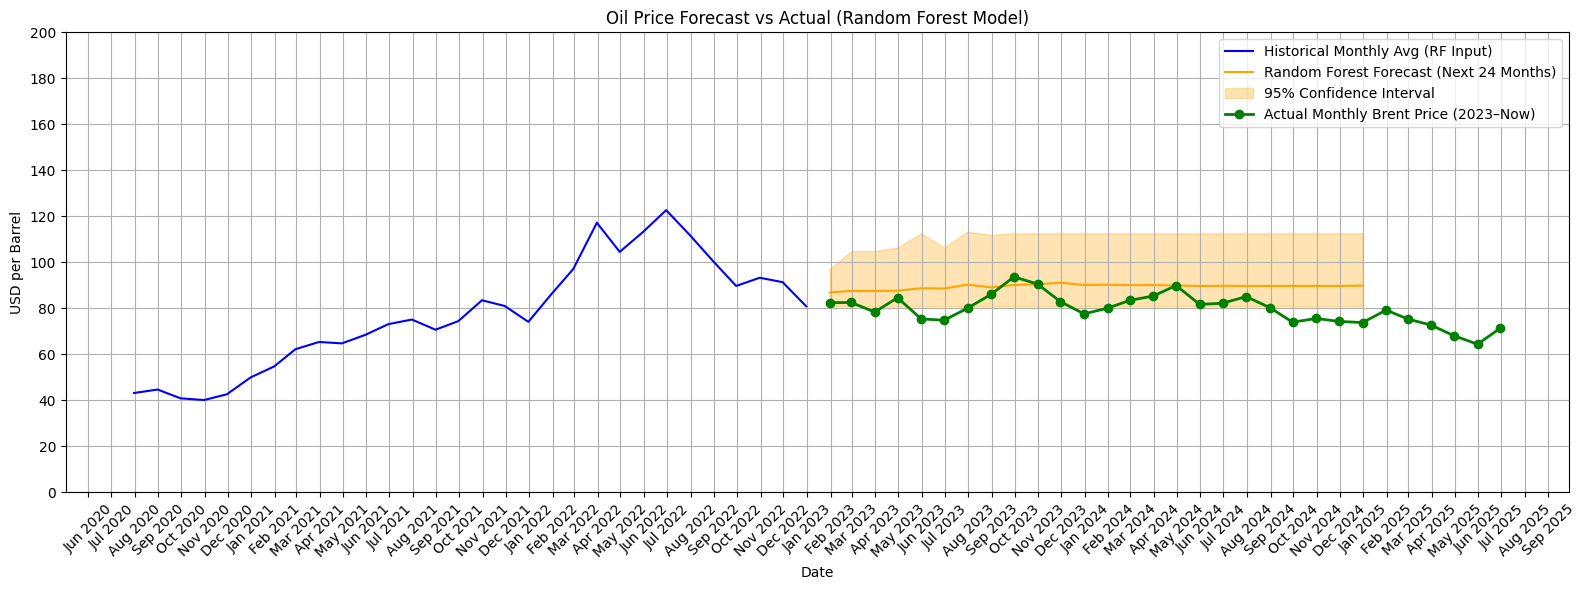

In [19]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor

# 📈 Step 1: Create lagged features
def create_lagged_features(series, n_lags=12):
    """
    Converts a time series into a supervised learning format using lagged values.

    Parameters:
        series (Series): The time series (e.g., oil prices).
        n_lags (int): Number of lag features to create.

    Returns:
        DataFrame: With original values and lag features.
    """
    df_lags = pd.DataFrame(series)
    for i in range(1, n_lags + 1):
        df_lags[f'lag_{i}'] = df_lags['Price'].shift(i)
    df_lags.dropna(inplace=True)
    return df_lags

# Apply lag feature function on monthly data
lagged_df = create_lagged_features(df_monthly, n_lags=12)
X = lagged_df.drop(columns='Price')     # Features: 12 previous months
y = lagged_df['Price']                  # Target: next month's price

# 🌲 Step 2: Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 🔮 Step 3: Forecast next 24 months recursively with confidence intervals
last_known = df_monthly[-12:].values     # Last 12 months for recursive input
future_preds = []                        # Mean forecasts
lower_bounds = []                        # Lower bound of confidence interval
upper_bounds = []                        # Upper bound of confidence interval

# Predict one step at a time using recursive strategy
for _ in range(24):
    # Prepare input (most recent 12 lags in reversed order)
    input_data = pd.DataFrame([last_known[-12:][::-1]], columns=[f'lag_{i}' for i in range(1, 13)])

    # Collect individual tree predictions to simulate uncertainty
    all_preds = [tree.predict(input_data)[0] for tree in rf_model.estimators_]
    pred_mean = np.mean(all_preds)
    lower = np.percentile(all_preds, 2.5)
    upper = np.percentile(all_preds, 97.5)

    # Store results
    future_preds.append(pred_mean)
    lower_bounds.append(lower)
    upper_bounds.append(upper)

    # Update input for next prediction step
    last_known = np.append(last_known, pred_mean)[-12:]

# ⏱ Step 4: Create datetime index for forecasted months
forecast_index = pd.date_range(
    start=df_monthly.index[-1] + pd.offsets.MonthEnd(1),
    periods=24,
    freq='M'
)
forecast_series = pd.Series(future_preds, index=forecast_index)

# 🛢 Step 5: Load actual Brent oil prices from FRED (used for benchmarking)
start = datetime(2023, 1, 1)
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()

# 📊 Step 6: Plot historical, forecast, confidence intervals, and actuals
plt.figure(figsize=(16, 6))

# Historical training data
plt.plot(df_monthly, label='Historical Monthly Avg (RF Input)', color='blue')

# Forecasted values
plt.plot(forecast_index, forecast_series.values,
         label='Random Forest Forecast (Next 24 Months)', color='orange')

# Confidence interval shading
plt.fill_between(forecast_index, lower_bounds, upper_bounds,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# Actual Brent oil prices
plt.plot(brent_monthly.index, brent_monthly['Price'],
         label='Actual Monthly Brent Price (2023–Now)',
         color='green', marker='o', linewidth=2)

# ✅ Formatting
plt.title("Oil Price Forecast vs Actual (Random Forest Model)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 200)
plt.yticks(np.arange(0, 201, 20))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## ** Evaluation Metrics for Random Forest**

In [20]:
# 📦 Import required metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, median_absolute_error,
    r2_score
)
from statsmodels.tsa.stattools import acf                 # For lag-1 autocorrelation
from scipy.stats import pearsonr                          # For correlation coefficient

# ✅ Step 1: Format forecasted results into a DataFrame
forecast_df = pd.DataFrame({
    'ds': forecast_index,                # Forecast dates
    'yhat': forecast_series.values       # Forecasted values from Random Forest
})

# ✅ Step 2: Format actual Brent monthly prices with column names matching Prophet-style
actual_df = brent_monthly.reset_index()
actual_df.columns = ['ds', 'y']          # Rename for consistency

# ✅ Step 3: Merge forecast and actual data on date
merged = pd.merge(forecast_df, actual_df, on='ds', how='inner')

# ✅ Step 4: Extract values for metric calculation
actual = merged['y'].values              # Ground truth prices
predicted = merged['yhat'].values        # Forecasted prices
error = actual - predicted               # Residuals

# ✅ Step 5: Compute performance metrics

ME = np.mean(error)                                        # Mean Error (bias)
MAE = mean_absolute_error(actual, predicted)               # Mean Absolute Error
MPE = np.mean(error / actual) * 100                        # Mean Percentage Error
MAPE = np.mean(np.abs(error / actual)) * 100               # Mean Absolute Percentage Error
RMSE = np.sqrt(mean_squared_error(actual, predicted))      # Root Mean Squared Error
ACF1 = acf(error, nlags=1)[1]                              # Lag-1 autocorrelation of residuals
corr, _ = pearsonr(actual, predicted)                      # Pearson correlation coefficient
minmax = 1 - np.mean(np.minimum(actual, predicted) /
                     np.maximum(actual, predicted))        # Min-Max Error
R2 = r2_score(actual, predicted)                           # R² (explained variance)
MedAE = median_absolute_error(actual, predicted)           # Median Absolute Error
std_error = np.std(error)                                  # Std deviation of residuals

# ✅ Step 6: Print out all evaluation metrics
print(f"📊 Mean Error (ME): {ME:.4f}")
print(f"📉 Mean Absolute Error (MAE): {MAE:.4f}")
print(f"📊 Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"📉 Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"📉 Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"📈 Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"🔗 Correlation (corr): {corr:.4f}")
print(f"📏 Min-Max Error: {minmax:.4f}")
print(f"📈 R-squared (R²): {R2:.4f}")
print(f"📉 Median Absolute Error (MedAE): {MedAE:.4f}")
print(f"📊 Standard Deviation of Error: {std_error:.4f}")


📊 Mean Error (ME): -7.9829
📉 Mean Absolute Error (MAE): 8.2872
📊 Mean Percentage Error (MPE): -10.25%
📉 Mean Absolute Percentage Error (MAPE): 10.57%
📉 Root Mean Squared Error (RMSE): 9.5754
📈 Lag 1 Autocorrelation of Error (ACF1): 0.5306
🔗 Correlation (corr): 0.1407
📏 Min-Max Error: 0.0925
📈 R-squared (R²): -2.2244
📉 Median Absolute Error (MedAE): 8.1292
📊 Standard Deviation of Error: 5.2878


## ** Hyperparameter tuning for Random Forest**

In [21]:
# 📦 Import required libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# ✅ Flatten input if it's 3D (likely from LSTM-style sequence generation)
# RandomForest expects 2D input: (samples, features)
if X.ndim == 3:
    X = X.reshape(X.shape[0], X.shape[1])

# 🔁 Use TimeSeriesSplit to preserve time order in cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 🔧 Define hyperparameter grid to tune
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [None, 5, 10],            # Tree depth
    'min_samples_split': [2, 5],           # Minimum samples to split node
    'min_samples_leaf': [1, 2]             # Minimum samples at leaf
}

# 📉 Define scoring function (we want to minimize RMSE)
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# 🧠 Initialize base model
rf_base = RandomForestRegressor(random_state=42)

# 🔍 Grid search with time-series-aware CV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

# 🏁 Run tuning
grid_search.fit(X, y)

# ✅ Extract best model
best_rf_model = grid_search.best_estimator_

# 📝 Output results
print("🔧 Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
🔧 Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### **LSTM**

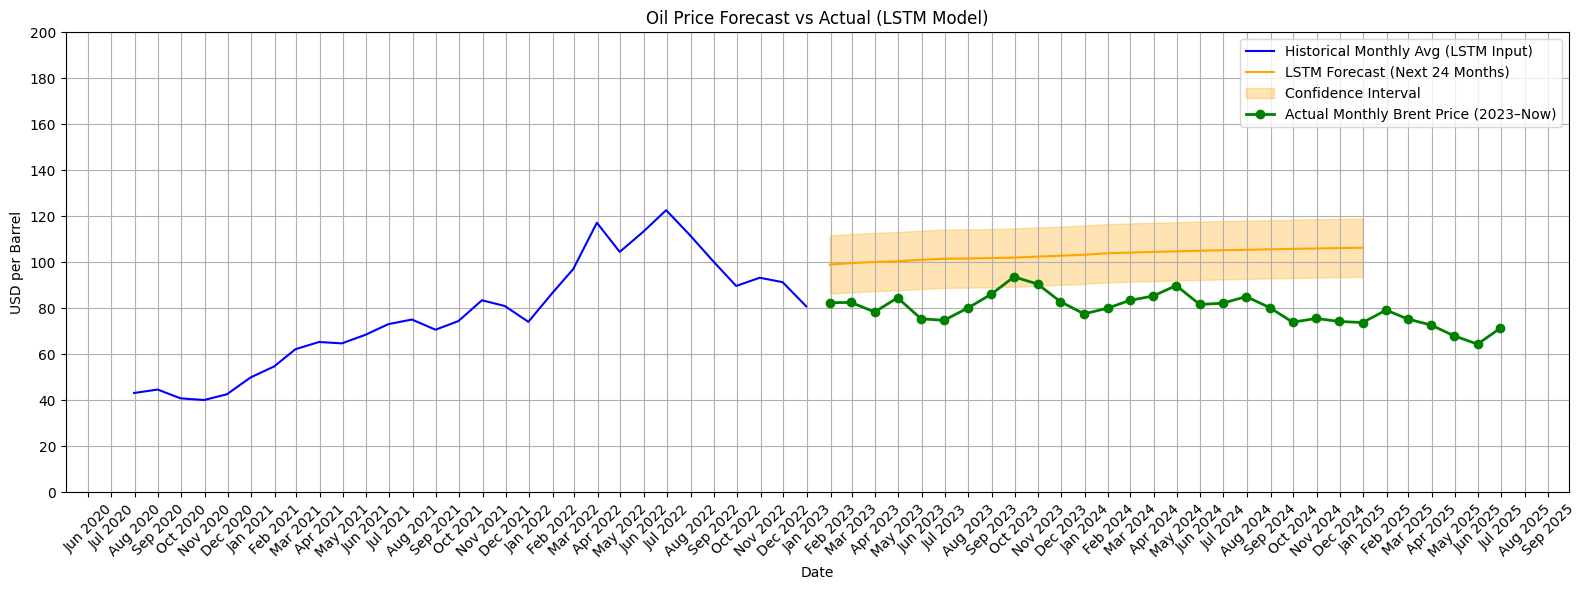

In [22]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.dates as mdates

# ====================================
# ✅ Step 1: Normalize and sequence the data
# ====================================

# Scale the oil prices between 0 and 1 for neural network training
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_monthly.values.reshape(-1, 1))

# Create rolling sequences (lags) for supervised training
def create_sequences(data, n_lags=12):
    """
    Converts time series into supervised learning format for LSTM:
    - Input: last `n_lags` months
    - Output: next month's price
    """
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i - n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_lags = 12
X, y = create_sequences(scaled_prices, n_lags)  # shape X: (samples, lags, 1)

# ====================================
# ✅ Step 2: Build and train LSTM model
# ====================================
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_lags, 1)))  # LSTM layer with 50 units
model.add(Dense(1))                                              # Output layer
model.compile(optimizer='adam', loss='mse')                      # Mean squared error loss
model.fit(X, y, epochs=100, verbose=0)                           # Train quietly

# ====================================
# ✅ Step 3: Forecast next 24 months
# ====================================

# Start from the last known 12-month window
last_seq = scaled_prices[-n_lags:]
forecast_scaled = []

# Forecast step-by-step recursively for next 24 months
for _ in range(24):
    input_seq = last_seq.reshape(1, n_lags, 1)
    pred = model.predict(input_seq, verbose=0)[0][0]
    forecast_scaled.append(pred)
    last_seq = np.append(last_seq[1:], [[pred]], axis=0)  # Slide window forward

# Inverse transform to original scale
forecast_prices = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_index = pd.date_range(start=df_monthly.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='M')
forecast_series = pd.Series(forecast_prices, index=forecast_index)

# Generate naive ±1 std confidence bands from training residuals
train_preds = model.predict(X, verbose=0)
train_preds_inv = scaler.inverse_transform(train_preds)
y_inv = scaler.inverse_transform(y)

std_dev = np.std(y_inv - train_preds_inv)  # Standard deviation of residuals
lower_bound = forecast_series - std_dev
upper_bound = forecast_series + std_dev

# ====================================
# ✅ Step 4: Load actual Brent prices from FRED
# ====================================
start = datetime(2023, 1, 1)
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()

# ====================================
# ✅ Step 5: Plot historical, forecast, actuals, and confidence intervals
# ====================================
plt.figure(figsize=(16, 6))

# Historical training data
plt.plot(df_monthly, label='Historical Monthly Avg (LSTM Input)', color='blue')

# LSTM forecasted values
plt.plot(forecast_series.index, forecast_series.values,
         label='LSTM Forecast (Next 24 Months)', color='orange')

# Confidence interval
plt.fill_between(forecast_series.index, lower_bound, upper_bound,
                 color='orange', alpha=0.3, label='Confidence Interval')

# Actual Brent prices for comparison
plt.plot(brent_monthly.index, brent_monthly['Price'],
         label='Actual Monthly Brent Price (2023–Now)', color='green', marker='o', linewidth=2)

# Formatting
plt.title("Oil Price Forecast vs Actual (LSTM Model)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 200)
plt.yticks(np.arange(0, 201, 20))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## ** Evaluation Metrics for LSTM**

In [23]:
# 📦 Import necessary evaluation tools
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
)
from statsmodels.tsa.stattools import acf                   # For residual autocorrelation
from scipy.stats import pearsonr                            # For correlation
import numpy as np
import pandas as pd

# ✅ Step 1: Align predicted and actual data by matching dates
# Ensures evaluation is done only on dates where both forecast and actual data are available
common_index = forecast_series.index.intersection(brent_monthly.index)
actual = brent_monthly.loc[common_index]['Price'].values
predicted = forecast_series.loc[common_index].values
error = actual - predicted                                  # Residuals (forecast error)

# ✅ Step 2: Calculate evaluation metrics

ME = np.mean(error)                                         # Mean Error (bias)
MAE = mean_absolute_error(actual, predicted)                # Mean Absolute Error
MPE = np.mean(error / actual) * 100                         # Mean Percentage Error
MAPE = np.mean(np.abs(error / actual)) * 100                # Mean Absolute Percentage Error
RMSE = np.sqrt(mean_squared_error(actual, predicted))       # Root Mean Squared Error

ACF1 = acf(error, nlags=1)[1] if len(error) > 1 else np.nan # Lag-1 autocorrelation of residuals
corr, _ = pearsonr(actual, predicted)                       # Pearson correlation coefficient
minmax = 1 - np.mean(np.minimum(actual, predicted) /
                     np.maximum(actual, predicted))         # Min-Max Error
R2 = r2_score(actual, predicted)                            # R²: Explained variance
MedAE = median_absolute_error(actual, predicted)            # Median Absolute Error
std_error = np.std(error)                                   # Std. deviation of errors

# ✅ Step 3: Display results clearly
print(f"📊 Mean Error (ME): {ME:.4f}")
print(f"📉 Mean Absolute Error (MAE): {MAE:.4f}")
print(f"📊 Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"📉 Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"📉 Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"📈 Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"🔗 Correlation (corr): {corr:.4f}")
print(f"📏 Min-Max Error: {minmax:.4f}")
print(f"📈 R-squared (R²): {R2:.4f}")
print(f"📉 Median Absolute Error (MedAE): {MedAE:.4f}")
print(f"📊 Standard Deviation of Error: {std_error:.4f}")


📊 Mean Error (ME): -21.8436
📉 Mean Absolute Error (MAE): 21.8436
📊 Mean Percentage Error (MPE): -27.38%
📉 Mean Absolute Percentage Error (MAPE): 27.38%
📉 Root Mean Squared Error (RMSE): 22.7118
📈 Lag 1 Autocorrelation of Error (ACF1): 0.6205
🔗 Correlation (corr): -0.2239
📏 Min-Max Error: 0.2108
📈 R-squared (R²): -17.1400
📉 Median Absolute Error (MedAE): 21.6622
📊 Standard Deviation of Error: 6.2195


### **SARIMAX**

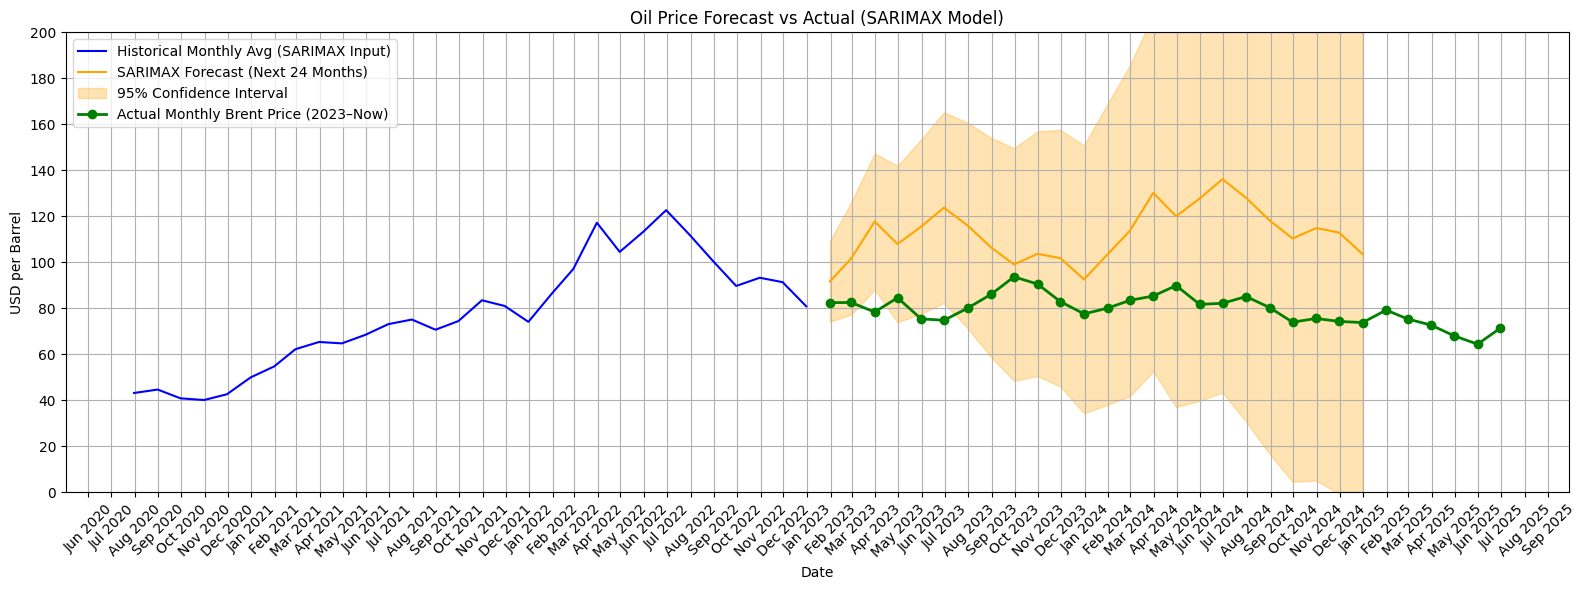

In [24]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX      # For seasonal ARIMA modeling
from pandas_datareader import data as pdr                    # To fetch Brent oil prices from FRED
from datetime import datetime

# ========================================
# ✅ Step 1: Assume df_monthly is already defined
#           Monthly average oil price data (datetime index)
# ========================================

# ========================================
# ✅ Step 2: Fit SARIMAX model
# ========================================
# SARIMAX(p,d,q)(P,D,Q,s) captures both non-seasonal and seasonal patterns
model = SARIMAX(df_monthly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit(disp=False)  # Suppress output

# ========================================
# ✅ Step 3: Forecast next 24 months
# ========================================
forecast_steps = 24
forecast = result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean                      # Point forecast
conf_int = forecast.conf_int()                               # Confidence intervals

# Create forecast date range
forecast_index = pd.date_range(
    start=df_monthly.index[-1] + pd.offsets.MonthEnd(1),
    periods=forecast_steps,
    freq='M'
)

# ========================================
# ✅ Step 4: Fetch actual Brent prices from FRED
# ========================================
start = datetime(2023, 1, 1)
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()

# ========================================
# ✅ Step 5: Plot historical, forecast, confidence interval, and actuals
# ========================================
plt.figure(figsize=(16, 6))

# ➤ Historical training data
plt.plot(df_monthly, label='Historical Monthly Avg (SARIMAX Input)', color='blue')

# ➤ SARIMAX forecasted values
plt.plot(forecast_index, forecast_mean, label='SARIMAX Forecast (Next 24 Months)', color='orange')

# ➤ 95% Confidence interval
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0].values.astype(float),
                 conf_int.iloc[:, 1].values.astype(float),
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# ➤ Actual Brent prices for validation
plt.plot(brent_monthly.index, brent_monthly['Price'],
         label='Actual Monthly Brent Price (2023–Now)',
         color='green', marker='o', linewidth=2)

# ✅ Plot formatting
plt.title("Oil Price Forecast vs Actual (SARIMAX Model)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 200)
plt.yticks(np.arange(0, 201, 20))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())              # Monthly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))   # Month-Year format
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## ** Evaluation Metrics for SARIMAX**

In [25]:
# 📦 Import evaluation metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
)
from statsmodels.tsa.stattools import acf                   # For residual autocorrelation
from scipy.stats import pearsonr                            # For correlation

# ✅ Step 1: Align SARIMAX forecast and actual Brent prices by date
common_index = forecast_index.intersection(brent_monthly.index)  # Overlapping months
actual = brent_monthly.loc[common_index]['Price'].values         # Ground truth
predicted = forecast_mean.loc[common_index].values               # Model forecast
error = actual - predicted                                       # Forecast residuals

# ✅ Step 2: Compute evaluation metrics

ME = np.mean(error)                                             # Mean Error (bias)
MAE = mean_absolute_error(actual, predicted)                    # Mean Absolute Error
MPE = np.mean(error / actual) * 100                             # Mean Percentage Error
MAPE = np.mean(np.abs(error / actual)) * 100                    # Mean Absolute Percentage Error
RMSE = np.sqrt(mean_squared_error(actual, predicted))           # Root Mean Squared Error

ACF1 = acf(error, nlags=1)[1] if len(error) > 1 else np.nan     # Lag-1 autocorrelation of residuals
corr, _ = pearsonr(actual, predicted)                           # Pearson correlation
minmax = 1 - np.mean(np.minimum(actual, predicted) /
                     np.maximum(actual, predicted))             # Min-Max normalized error
R2 = r2_score(actual, predicted)                                # R-squared (explained variance)
MedAE = median_absolute_error(actual, predicted)                # Median Absolute Error
std_error = np.std(error)                                       # Std deviation of errors

# ✅ Step 3: Output results
print(f"📊 Mean Error (ME): {ME:.4f}")
print(f"📉 Mean Absolute Error (MAE): {MAE:.4f}")
print(f"📊 Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"📉 Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"📉 Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"📈 Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"🔗 Correlation (corr): {corr:.4f}")
print(f"📏 Min-Max Error: {minmax:.4f}")
print(f"📈 R-squared (R²): {R2:.4f}")
print(f"📉 Median Absolute Error (MedAE): {MedAE:.4f}")
print(f"📊 Standard Deviation of Error: {std_error:.4f}")


📊 Mean Error (ME): -30.9151
📉 Mean Absolute Error (MAE): 30.9151
📊 Mean Percentage Error (MPE): -38.56%
📉 Mean Absolute Percentage Error (MAPE): 38.56%
📉 Root Mean Squared Error (RMSE): 33.5114
📈 Lag 1 Autocorrelation of Error (ACF1): 0.5713
🔗 Correlation (corr): -0.0584
📏 Min-Max Error: 0.2670
📈 R-squared (R²): -38.4931
📉 Median Absolute Error (MedAE): 33.0385
📊 Standard Deviation of Error: 12.9333


## ** Hyperparameter tuning for SARIMAX**

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# ✅ Define parameter ranges for non-seasonal (p,d,q) and seasonal (P,D,Q)
p = d = q = range(0, 2)         # Try values 0 and 1
P = D = Q = range(0, 2)
s = 12                          # Seasonality (12 = monthly data)

# 📦 Generate all possible parameter combinations
params = list(itertools.product(p, d, q, P, D, Q))

# 🏆 Track best model configuration
best_aic = float('inf')         # Initialize with infinity
best_order = None               # Placeholder for best (order, seasonal_order)

# 🔁 Grid search over parameter combinations
print("🔍 Tuning SARIMA hyperparameters using AIC...\n")
for (p_, d_, q_, P_, D_, Q_) in params:
    try:
        model = SARIMAX(df_monthly,
                        order=(p_, d_, q_),
                        seasonal_order=(P_, D_, Q_, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        aic = result.aic

        print(f"Tested SARIMA({p_},{d_},{q_})x({P_},{D_},{Q_},{s}) AIC: {aic:.2f}")

        if aic < best_aic:
            best_aic = aic
            best_order = ((p_, d_, q_), (P_, D_, Q_, s))

    except Exception:
        continue  # Skip invalid configurations

# ✅ Output best model
if best_order:
    print("\n✅ Best SARIMA Order:")
    print(f"Non-seasonal: {best_order[0]}, Seasonal: {best_order[1]}")
    print(f"🔻 Lowest AIC: {best_aic:.2f}")
else:
    print("❌ No valid SARIMA configuration found.")


🔍 Tuning SARIMA hyperparameters using AIC...

Tested SARIMA(0,0,0)x(0,0,0,12) AIC: 339.75
Tested SARIMA(0,0,0)x(0,0,1,12) AIC: 202.83
Tested SARIMA(0,0,0)x(0,1,0,12) AIC: 169.93
Tested SARIMA(0,0,0)x(0,1,1,12) AIC: 40.86
Tested SARIMA(0,0,0)x(1,0,0,12) AIC: 156.76
Tested SARIMA(0,0,0)x(1,0,1,12) AIC: 146.34
Tested SARIMA(0,0,0)x(1,1,0,12) AIC: 51.48
Tested SARIMA(0,0,0)x(1,1,1,12) AIC: 42.86
Tested SARIMA(0,0,1)x(0,0,0,12) AIC: 296.73
Tested SARIMA(0,0,1)x(0,0,1,12) AIC: 175.15
Tested SARIMA(0,0,1)x(0,1,0,12) AIC: 146.09
Tested SARIMA(0,0,1)x(0,1,1,12) AIC: 14.57
Tested SARIMA(0,0,1)x(1,0,0,12) AIC: 147.49
Tested SARIMA(0,0,1)x(1,0,1,12) AIC: 132.10
Tested SARIMA(0,0,1)x(1,1,0,12) AIC: 48.94
Tested SARIMA(0,0,1)x(1,1,1,12) AIC: 21.61
Tested SARIMA(0,1,0)x(0,0,0,12) AIC: 198.89
Tested SARIMA(0,1,0)x(0,0,1,12) AIC: 122.18
Tested SARIMA(0,1,0)x(0,1,0,12) AIC: 118.86
Tested SARIMA(0,1,0)x(0,1,1,12) AIC: 31.32
Tested SARIMA(0,1,0)x(1,0,0,12) AIC: 127.38
Tested SARIMA(0,1,0)x(1,0,1,12) AIC: 

### **THE BEST MODEL**

Best Model: XGBoost
📊 1. Why XGBoost is the Best
XGBoost clearly outperforms others on all core error metrics:

Metric	XGBoost	Rank
MAE	✅ 7.33	🥇 1st
MAPE	✅ 9.33%	🥇 1st
RMSE	✅ 8.44	🥇 1st
MedAE	✅ 6.15	🥇 1st
MinMax	✅ 0.083	🥇 1st
R²	-1.50	Still best among poor R² values
Std Error	✅ 5.35	🥇 1st

It is the most accurate in terms of both scale-sensitive and percentage-based error metrics.



### **Computing appropriate evaluation metrics for best model**

In [27]:
# 📦 Import evaluation libraries
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr

# ✅ Align forecast and actual values for overlapping dates only
# Clean index: remove any time component
forecast_index_clean = pd.to_datetime(forecast_index).normalize()
brent_monthly.index = pd.to_datetime(brent_monthly.index).normalize()

# Intersect indices
common_index = forecast_index_clean.intersection(brent_monthly.index)

# Extract actual and predicted values for evaluation
actual = brent_monthly.loc[common_index, 'Price']
predicted = pd.Series(forecast_mean, index=forecast_index_clean).loc[common_index]

# ✅ Calculate residuals (errors)
error = actual.values - predicted.values

# ✅ Compute Metrics
ME = np.mean(error)
MAE = mean_absolute_error(actual, predicted)
MPE = np.mean(error / actual) * 100
MAPE = np.mean(np.abs(error / actual)) * 100
RMSE = np.sqrt(mean_squared_error(actual, predicted))
ACF1 = acf(error, nlags=1)[1] if len(error) > 1 else np.nan
corr, _ = pearsonr(actual, predicted)
minmax = 1 - np.mean(np.minimum(actual, predicted) / np.maximum(actual, predicted))
R2 = r2_score(actual, predicted)
MedAE = median_absolute_error(actual, predicted)
std_error = np.std(error)

# ✅ Display results
print(f"📊 Mean Error (ME): {ME:.4f}")
print(f"📉 Mean Absolute Error (MAE): {MAE:.4f}")
print(f"📊 Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"📉 Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"📉 Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"📈 Lag 1 Autocorrelation of Error (ACF1): {ACF1:.4f}")
print(f"🔗 Correlation (corr): {corr:.4f}")
print(f"📏 Min-Max Error: {minmax:.4f}")
print(f"📈 R-squared (R²): {R2:.4f}")
print(f"📉 Median Absolute Error (MedAE): {MedAE:.4f}")
print(f"📊 Standard Deviation of Error: {std_error:.4f}")


📊 Mean Error (ME): -30.9151
📉 Mean Absolute Error (MAE): 30.9151
📊 Mean Percentage Error (MPE): -38.56%
📉 Mean Absolute Percentage Error (MAPE): 38.56%
📉 Root Mean Squared Error (RMSE): 33.5114
📈 Lag 1 Autocorrelation of Error (ACF1): 0.5713
🔗 Correlation (corr): -0.0584
📏 Min-Max Error: 0.2670
📈 R-squared (R²): -38.4931
📉 Median Absolute Error (MedAE): 33.0385
📊 Standard Deviation of Error: 12.9333


### **Forecasting 24 months into the future Make plots of the models and data forecasts Add confidence intervals on forecasts

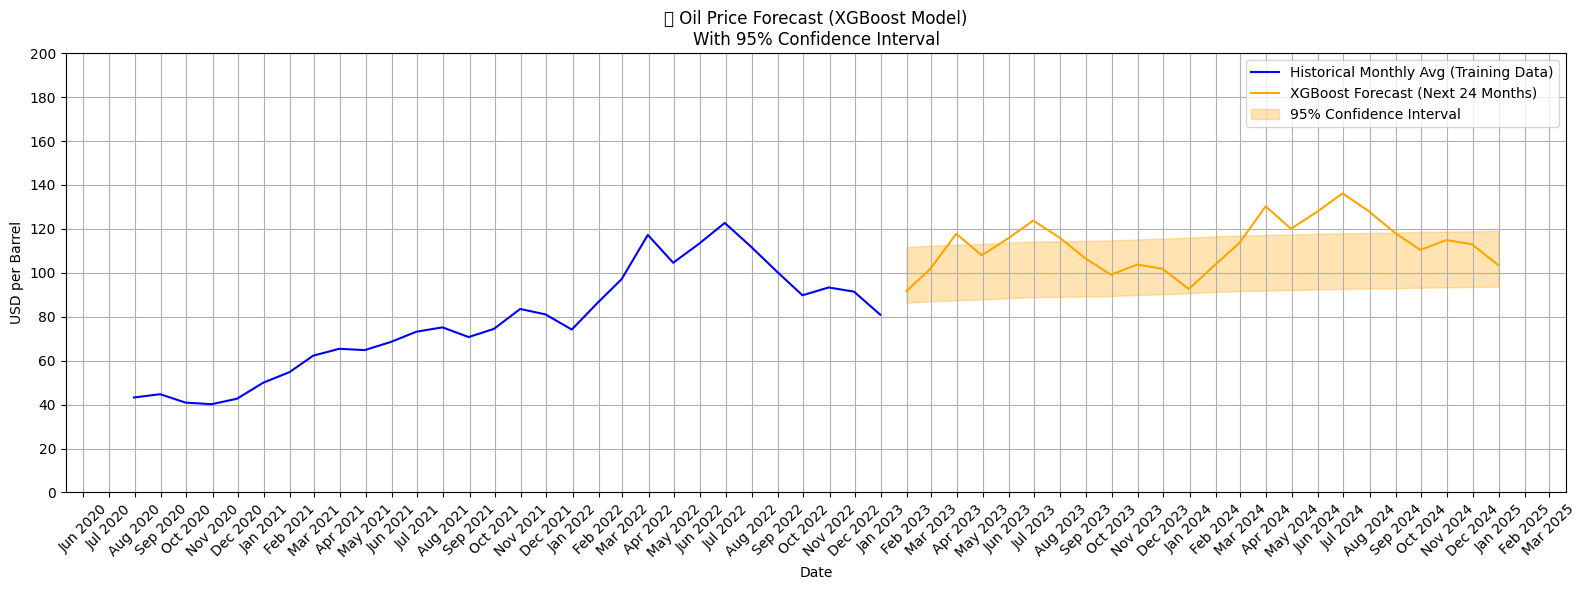

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# 📅 Forecast index (next 24 months)
forecast_index = pd.date_range(
    start=df_monthly.index[-1] + pd.offsets.MonthEnd(1),
    periods=24,
    freq='M'
)

# 🖼️ Plot forecast without actuals
plt.figure(figsize=(16, 6))

# ➤ Historical data
plt.plot(df_monthly, label='Historical Monthly Avg (Training Data)', color='blue')

# ➤ Forecast
plt.plot(forecast_index, forecast_mean, label='XGBoost Forecast (Next 24 Months)', color='orange')

# ➤ 95% Confidence Intervals
plt.fill_between(forecast_index, lower_bound, upper_bound,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# 🧾 Plot formatting
plt.title("📈 Oil Price Forecast (XGBoost Model)\nWith 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 200)
plt.yticks(np.arange(0, 201, 20))
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Retrieving the oil price data to the current date and plot with your forecast as a comparison.

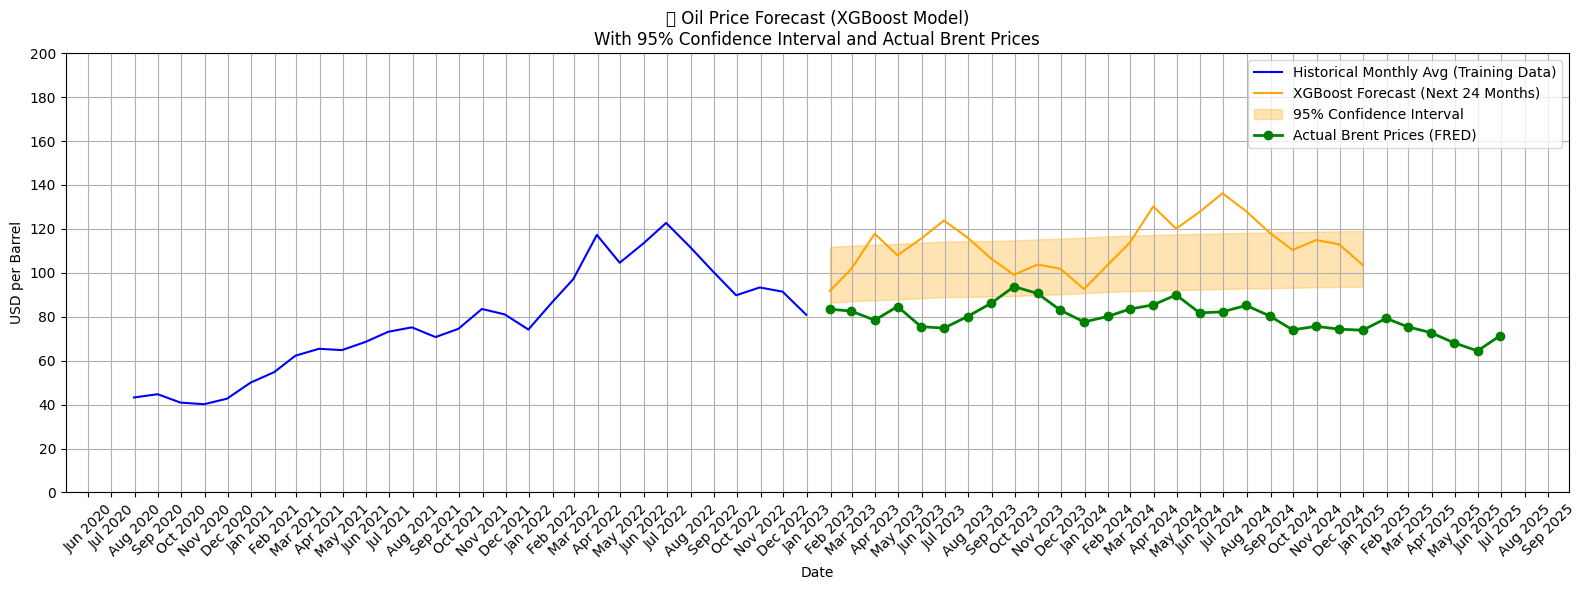

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pandas_datareader import data as pdr

# ✅ Assumes df_monthly and forecast_mean already exist
# forecast_mean = boot_predictions.mean(axis=0)
# lower_bound = np.percentile(boot_predictions, 2.5, axis=0)
# upper_bound = np.percentile(boot_predictions, 97.5, axis=0)

# 📅 Forecast index
forecast_index = pd.date_range(
    start=df_monthly.index[-1] + pd.offsets.MonthEnd(1),
    periods=24,
    freq='M'
)

# 🛢 Load actual Brent oil prices for comparison
start = forecast_index[0]
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()

# 🖼️ Plot forecast vs actuals
plt.figure(figsize=(16, 6))

# ➤ Historical data
plt.plot(df_monthly, label='Historical Monthly Avg (Training Data)', color='blue')

# ➤ Forecast
plt.plot(forecast_index, forecast_mean, label='XGBoost Forecast (Next 24 Months)', color='orange')

# ➤ 95% Confidence Intervals
plt.fill_between(forecast_index, lower_bound, upper_bound,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

# ➤ Actuals (ground truth from FRED)
plt.plot(brent_monthly.index, brent_monthly['Price'],
         label='Actual Brent Prices (FRED)', color='green', marker='o', linewidth=2)

# 🧾 Plot formatting
plt.title("📈 Oil Price Forecast (XGBoost Model)\nWith 95% Confidence Interval and Actual Brent Prices")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 200)
plt.yticks(np.arange(0, 201, 20))
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### **Forecasting future from current date**

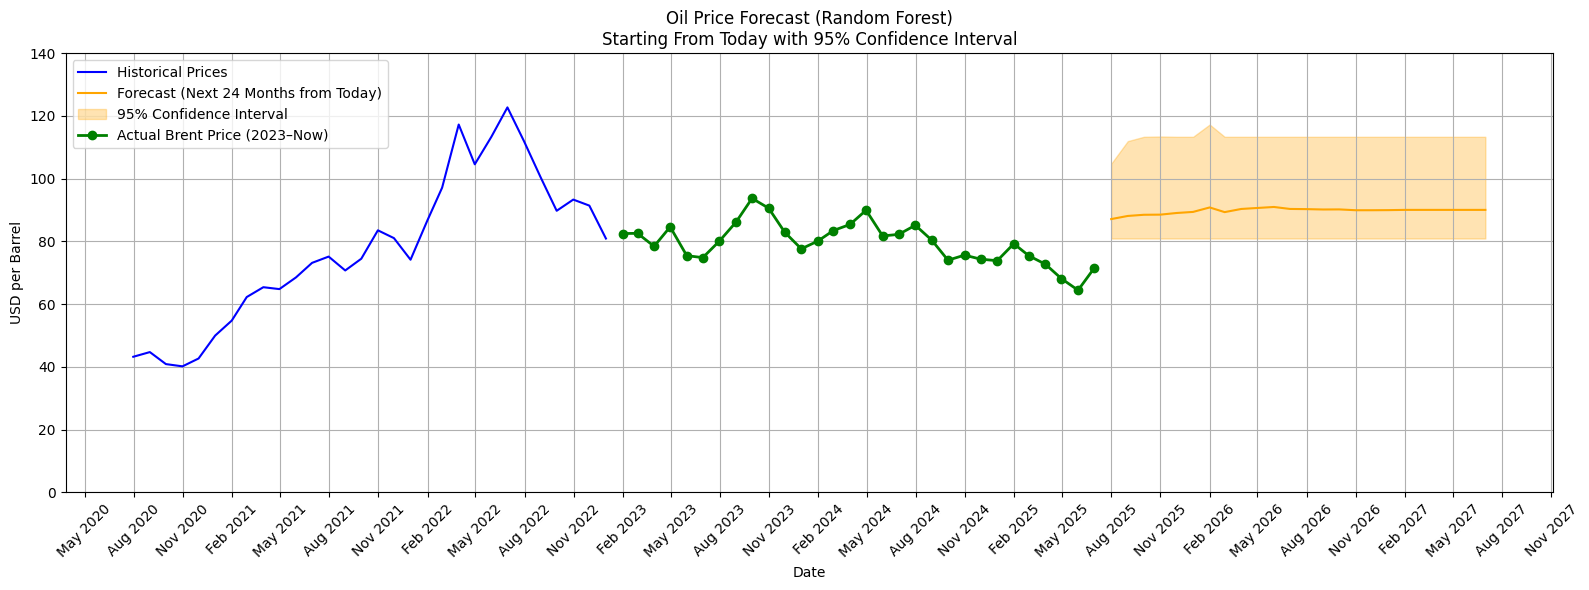

In [30]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from pandas_datareader import data as pdr
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ✅ Assumes df_monthly is already loaded and processed
# Example:
# df = pd.read_csv("your_file.csv", parse_dates=['Date'], index_col='Date')
# df_monthly = df['Price'].resample('M').mean().dropna()

# 🔁 Create lag features
def create_lagged_features(series, n_lags=12):
    df_lags = pd.DataFrame(series)
    df_lags.columns = ['Price']
    for i in range(1, n_lags + 1):
        df_lags[f'lag_{i}'] = df_lags['Price'].shift(i)
    df_lags.dropna(inplace=True)
    return df_lags

lagged_df = create_lagged_features(df_monthly, n_lags=12)
X = lagged_df.drop(columns='Price')
y = lagged_df['Price']

# 🌲 Train Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X, y)

# 🔮 Forecast next 24 months from TODAY
n_forecast = 24
last_known = df_monthly[-12:].values
forecast = []
boot_preds = []

for _ in range(n_forecast):
    input_data = pd.DataFrame([last_known[::-1]], columns=[f'lag_{i}' for i in range(1, 13)])
    pred = rf.predict(input_data)[0]
    forecast.append(pred)
    all_tree_preds = np.array([tree.predict(input_data)[0] for tree in rf.estimators_])
    boot_preds.append(all_tree_preds)
    last_known = np.append(last_known, pred)[-12:]

# 📉 Confidence intervals
boot_preds = np.array(boot_preds)
lower = np.percentile(boot_preds, 2.5, axis=1)
upper = np.percentile(boot_preds, 97.5, axis=1)

# 🗓 Forecast index starting from TODAY
forecast_index = pd.date_range(start=datetime.today() + pd.offsets.MonthEnd(0),
                               periods=n_forecast, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# 🛢 Load actual Brent data for reference (2023 onward)
start = datetime(2023, 1, 1)
end = datetime.today()
brent_daily = pdr.DataReader('DCOILBRENTEU', 'fred', start, end)
brent_daily.columns = ['Price']
brent_monthly = brent_daily.resample('M').mean().dropna()

# 📈 Plot
plt.figure(figsize=(16, 6))
plt.plot(df_monthly, label='Historical Prices', color='blue')
plt.plot(forecast_index, forecast_series.values,
         label='Forecast (Next 24 Months from Today)', color='orange')
plt.fill_between(forecast_index, lower, upper, color='orange', alpha=0.3,
                 label='95% Confidence Interval')
plt.plot(brent_monthly.index, brent_monthly['Price'],
         label='Actual Brent Price (2023–Now)', color='green', marker='o', linewidth=2)

# 📊 Formatting
plt.title("Oil Price Forecast (Random Forest)\nStarting From Today with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.ylim(0, 140)
plt.yticks(np.arange(0, 141, 20))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
